# Prevayl Technical Task

Task 1

- From the data available in the data/transformer folder provided. Can you please complete the following:
  
  a) construct a simple transformer model using a library of your choice. (If you are struggling to get started have a look at this implementation https://keras.io/examples/generative/text_generation_with_miniature_gpt/)
  
  b) Train the model (Ok to train this on a smaller sample if necessary)
  
  c) Test the model and report the model accuracy
  
  d) Provide and evaluation of the accuracy and what could be done to improve the accuracy and robustness of the model

Task 2

- From the data available in the data/health folder provided. Can you please complete the following:

  a) Perform a exploratory data analysis on the dataset as if you were preparing it to build a predictive model.
  
  b) Provide a summary of your findings




## Instructions to Run

Hi! Thanks for reviewing my submission. 

Throughout this notebook I have tried to lay out the code as I would in practice, with clear docstrings, type hints and a logical structure. I have annotated the notebook as I go along explaining exactly what is happening in each step.

To ensure this notebook can be run by anyone, I have included some `requirements` files as well as a `Makefile` and some scripts to make creating a compatible environment easy. 

## Set up and installation

You must have some form of Conda installed for this to work. 

Run the command below from the root directory, and answer `y` when asked about installation of dependencies.

**This will automatically create a conda environment and ipykernel kernel called `transformer_from_scratch` for use in a jupyter notebook.** 

```shell
make create_environment
```

**Note** As I am running on Mac, my requirements include `tensorflow-macos` if you are running on another system, simply remove the `-macos` from the line in `requirements.txt` and it should work fine (tested on EC2 instance). 

If you need to update the dependencies, simply add the new package name(s) to `requirements.in` and then run:

```shell
make update_requirements

make dev_install
```

This will use pip-tools to search for compatible versions of all dependencies, then install the new dependencies in your conda environment. 







# Task 1


## Load dependencies


In [32]:
import json
import re
from datetime import datetime
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from langdetect import DetectorFactory, detect
from loguru import logger
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import ParameterGrid, train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import (Dense, Dropout, Embedding, Input, Layer,
                                     LayerNormalization, MultiHeadAttention)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

## Load Data

In [3]:
# Suggested way to filter the dataset. Feel free to remove this if you want to

# Load the full dataset
with open(r"data/transformer/winemag-data-130k-v2.json") as json_data:
    wine_data = json.load(json_data)

# Filter the dataset
filtered_data = [
    "wine review : "
    + x["country"]
    + " : "
    + x["province"]
    + " : "
    + x["variety"]
    + " : "
    + x["description"]
    for x in wine_data
    if x["country"] is not None
    and x["province"] is not None
    and x["variety"] is not None
    and x["description"] is not None
]

### Basic EDA

- Upon inspecting the size and quantity of the documents (130K x 50 words) it was clear that I was likely to struggle to train a model with all of the data given the time constraints of the task  **so decided to train with a small sample**.
- I plotted the distribution of lengths and saw there was a a slightly long right tail, rather than randomly sample and potentially have lots of padding tokens, I chose to select 10,000 documents with approximately 50 words.
- I also noticed that there were several special characters in the texts. Given the domain context, I decided to retain most the special characters as they likely belong to names of wines or places.
- I did a further check to ensure all the documents were in English using `landetect`, luckily they are!

The total number of documents is: 129907
The median of document length is: 49.0
The mean of document length is: 50.28


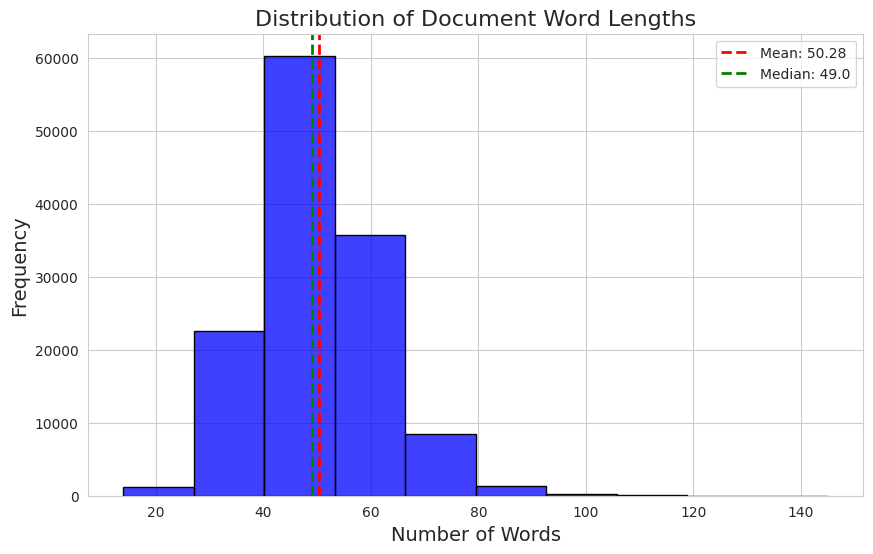

In [241]:
# Calculate Text Lengths
text_lengths = [len(document.split(" ")) for document in filtered_data]

# Calculate mean and median
mean_length = np.mean(text_lengths)
median_length = np.median(text_lengths)

# Display the number of documents, median, and mean
print(f"The total number of documents is: {len(filtered_data)}")
print(f"The median of document length is: {median_length}")
print(f"The mean of document length is: {mean_length:.2f}")

sns.set_style("whitegrid")

# Create the histogram plot
plt.figure(figsize=(10, 6))
sns.histplot(text_lengths, bins=10, kde=False, color="blue", edgecolor="black")

# Add mean line
plt.axvline(
    mean_length,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean: {mean_length:.2f}",
)

# Add median line (optional)
plt.axvline(
    median_length,
    color="green",
    linestyle="--",
    linewidth=2,
    label=f"Median: {median_length}",
)

plt.title("Distribution of Document Word Lengths", fontsize=16)
plt.xlabel("Number of Words", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

plt.legend()

plt.grid(True)
plt.show()

In [242]:
# Sample data for testing
# Filter documents with word count between 45 and 55 words to minimize padding
filtered_documents = [doc for doc in filtered_data if 45 <= len(doc.split(" ")) <= 55]
data = filtered_documents[:10000]
print(data[0])

wine review : Portugal : Douro : Portuguese Red : This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's  already drinkable, although it will certainly be better from 2016.


In [243]:
# Examining Unique Characters in corpus
unique_characters = {char for document in data for char in document}
print(unique_characters)

{',', 'ì', 'p', 'ǎ', 'M', '/', 'S', 'ö', 'H', 'ô', 'ü', 'l', 'g', 'A', 'P', 'e', '&', '(', 'n', 'i', '—', 'r', '“', 'G', 'ò', 'à', ':', 'b', 'ÿ', 'm', 'ë', 'R', 'É', 'á', 'è', 'û', '7', 'T', 'ã', 'â', "'", '$', '6', 'ç', '+', 'a', 'í', 'ó', 'E', '5', ' ', 'Q', 'š', '?', 'X', 'C', '3', 'v', '8', 'x', 'î', 'L', 'j', 'w', 'q', '’', ';', 'ù', 'K', 'č', 'o', 'Ö', 'f', '0', 'z', 'W', '%', 'c', ')', 'B', '4', 'Y', 'd', '1', '9', '.', 'é', 'I', '‘', '-', 'J', '”', 'ê', 'Z', '2', 'h', 'U', 'y', 't', 'O', 'ä', '\xad', 'k', 'N', 'F', 'D', 's', 'ñ', '!', 'u', 'ú', '–', 'V'}


In [244]:
# Checking all documents in corpus are in English...


def is_english(text):
    try:
        return detect(text) == "en"
    except:
        return False


all_english = all(is_english(document) for document in data)

if all_english:
    logger.success("All documents are in English.")
else:
    logger.warning("Not all documents are in English.")

2024-07-24 15:29:25.191 | SUCCESS  | __main__:<module>:11 - All documents are in English.


### Basic Text Pre-Processing

- I applied some extremely basic text pre-processing.
- I want to preserve the syntactic structure of the texts as much possible, so that the model can learn form it whilst making them easier to tokenize.

In [245]:
def basic_text_preprocessing(document: str) -> str:
    """Perform basic text preprocessing including removing extra whitespace, linebreaks and anyting that can confuse our tokenizer.

    Parameters
    ----------
    document : str
        The input text to be preprocessed.

    Returns
    -------
    str
        The preprocessed text.
    """
    # Remove leading and trailing whitespace
    document = document.strip()
    # Replace multiple spaces with a single space
    document = re.sub(r"\s+", " ", document)
    # Remove line breaks
    document = document.replace("\n", " ").replace("\r", " ")
    # Remove \xad character
    document = document.replace("\xad", " ").replace("\r", " ")

    return document

In [246]:
data = [basic_text_preprocessing(doc) for doc in data]
data[0]

"wine review : Portugal : Douro : Portuguese Red : This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's already drinkable, although it will certainly be better from 2016."

## Tokenize the data

I decided to write some functions to perform the tokenization and data preparation. While not strictly necessary I wanted to show how I like to write functions, using complete docstrings with proper type hinting.

1. `create_tokenizer(data: List[str]) -> Tokenizer`:
   - This function creates and fits a Tokenizer object on the provided text data.
   - It takes a list of text documents (`data`) as input and returns a fitted Tokenizer instance.
   - The Tokenizer is fitted using the `fit_on_texts()` method, which learns the vocabulary and assigns integer indices to each token.

2. `texts_to_sequences(tokenizer: Tokenizer, data: List[str]) -> List[List[int]]`:
   - This function converts text documents into sequences of integers using a fitted Tokenizer.
   - It takes a fitted Tokenizer instance (`tokenizer`) and a list of text documents (`data`) as input.
   - It returns a list of sequences, where each sequence is a list of integers representing the token indices.
   - The conversion is performed using the `texts_to_sequences()` method of the Tokenizer.

3. `prepare_data_for_training(padded_sequences: np.ndarray) -> Tuple[np.ndarray, np.ndarray]`:
   - This function prepares input and output data for training by creating input-output pairs from padded sequences.
   - It takes a 2D numpy array of padded sequences (`padded_sequences`) as input, where each row represents a sequence of tokens.
   - It generates input (`X`) and output (`y`) pairs by sliding a window over the padded sequences.
   - The input sequences (`X`) are created by excluding the last token from each sequence.
   - The output sequences (`y`) are created by excluding the first token from each sequence.
   - The function returns a tuple containing the input data (`X`) and the output data (`y`).
   - The purpose of this approach is to allow the model to learn to predict the next token based on the preceding tokens.



In [12]:
def create_tokenizer(data: List[str]) -> Tokenizer:
    """
    Create and fit a Tokenizer on the provided text data.

    Parameters
    ----------
    data : List[str]
        A list of text documents to fit the Tokenizer on.

    Returns
    -------
    Tokenizer
        A fitted Tokenizer instance ready for text-to-sequence conversion.
    """
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data)
    return tokenizer


def texts_to_sequences(tokenizer: Tokenizer, data: List[str]) -> List[List[int]]:
    """
    Convert text documents into sequences of integers using the fitted Tokenizer.

    Parameters
    ----------
    tokenizer : Tokenizer
        A Tokenizer instance that has been fitted on the text data.
    data : List[str]
        A list of text documents to convert into sequences.

    Returns
    -------
    List[List[int]]
        A list of sequences where each sequence is a list of integers representing token indices.
    """
    return tokenizer.texts_to_sequences(data)


def prepare_data_for_training(
    padded_sequences: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Prepare input and output data for training by creating input-output pairs from the padded sequences.

    The function generates input (`X`) and output (`y`) pairs by sliding a window over the padded sequences.
    The input sequences (`X`) are created by excluding the last token from each sequence,
    while the output sequences (`y`) are created by excluding the first token. This approach
    allows the model to learn to predict the next token based on the preceding tokens.

    Parameters
    ----------
    padded_sequences : np.ndarray
        A 2D numpy array of padded sequences where each row represents a sequence of tokens.

    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        A tuple containing:
        - np.ndarray
            Input data (`X`) where each row is a sequence of tokens excluding the last token.
        - np.ndarray
            Output data (`y`) where each row is a sequence of tokens excluding the first token.

    Example
    -------
    Given a padded sequence like:
    [[1, 2, 3, 4],
     [5, 6, 7, 0]]

    - Input data (`X`) will be:
    [[1, 2, 3],
     [5, 6, 7]]

    - Output data (`y`) will be:
    [[2, 3, 4],
     [6, 7, 0]]

    """
    X = padded_sequences[:, :-1]
    y = padded_sequences[:, 1:]
    return X, y

In [13]:
# Tokenize
tokenizer = create_tokenizer(data)

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(data)

# Pad sequences
max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding="pre")

# Define vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token

X, y = prepare_data_for_training(padded_sequences)
# Convert labels to one-hot encoding
y = tf.keras.utils.to_categorical(y, num_classes=vocab_size)


print("Vocabulary Size:", vocab_size)
print("Max Sequence Length:", max_sequence_length)
print("Input Shape:", X.shape)
print("Output Shape:", y.shape)

Vocabulary Size: 11683
Max Sequence Length: 61
Input Shape: (10000, 60)
Output Shape: (10000, 60, 11683)


## Create the training set


After conducting basic exploratory data analysis and preprocessing, I split the dataset into training, validation, and testing sets using the `train_test_split` function from the `sklearn.model_selection` module.

First, I performed an initial split to separate the data into training and temporary sets using a test size of 0.4. This means that 60% of the data was allocated for training, while the remaining 40% was set aside for further splitting.


Next, I split the temporary set equally into validation and testing sets using a test size of 0.5.


The resulting split proportions are as follows:
- Training set: 60% of the data
- Validation set: 20% of the data   <- For validation whilst training
- Testing set: 20% of the data      <- Completely unseen, holdout set for later evaluation

I used a fixed random state of 13 for reproducibility purposes, ensuring that the same split is obtained each time the code is run.


In [22]:
# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=13
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=13
)

In [23]:
print(X_train.shape)
print(y_train.shape)

(6000, 60)
(6000, 60, 11683)


## Create the Transformer

In order to build the transformer model, I needed to create some custom layers using Python Classes. While this is an extremely simple model, I hope this illustrates how I would go about building a more complex one.

I decided to create two: `TransformerBlock` and `TokenAndPositionEmbedding`. 

The `TransformerBlock` class is a single transformer block, which has a multi-head attention layer followed by a feed-forward network. It also includes layer normalization and dropout for regularization.

The key parts are:
- `att`: The multi-head attention layer, this allows the model to focus on different parts of the input sequence.
- `ffn`: The feed-forward network that applies some non-linear transformations to the attention output.
- `layernorm1` and `layernorm2`: Layer normalization layers that are applied after the attention output and feed-forward network output.
- `dropout1` and `dropout2`: Dropout layers applied after the attention output and feed-forward network output to help prevent overfitting.

The `call` method of the `TransformerBlock` does the forward pass:
1. It creates a causal mask to hide future tokens during self-attention (more on this later).
2. It applies the multi-head attention layer to the input tensor.
3. It applies dropout to the attention output.
4. It applies layer normalization to the sum of the input tensor and the attention output.
5. It passes the normalized output through the feed-forward network.
6. It applies dropout to the feed-forward network output.
7. It applies layer normalization to the sum of the normalized attention output and the feed-forward network output.

I also created a `_create_causal_mask` helper method that creates a causal mask. This is to make sure the model can't attend to future tokens during self-attention.

The `TokenAndPositionEmbedding` class combines token embeddings with positional embeddings. It maps input tokens to dense vectors and adds positional information to capture the sequential nature of the input.

The key parts are:
- `token_emb`: The embedding layer that maps input tokens to dense vectors.
- `pos_emb`: The embedding layer that generates positional embeddings based on the position of each token.

The `call` method of the `TokenAndPositionEmbedding` does the forward pass:
1. It gets the maximum sequence length from the input tensor.
2. It generates positional embeddings using the `pos_emb` layer.
3. It applies token embeddings to the input tensor using the `token_emb` layer.
4. It adds the token embeddings and positional embeddings element-wise.



In [14]:
class TransformerBlock(Layer):
    """
    Transformer block layer.

    Parameters
    ----------
    embed_dim : int
        Dimensionality of the embedding space.
    num_heads : int
        Number of attention heads.
    ff_dim : int
        Dimensionality of the feed-forward network.
    rate : float, optional
        Dropout rate, by default 0.1.

    Attributes
    ----------
    att : MultiHeadAttention
        Multi-head attention layer.
    ffn : tf.keras.Sequential
        Feed-forward network.
    layernorm1 : LayerNormalization
        Layer normalization applied after the attention output.
    layernorm2 : LayerNormalization
        Layer normalization applied after the feed-forward network output.
    dropout1 : Dropout
        Dropout layer applied after the attention output.
    dropout2 : Dropout
        Dropout layer applied after the feed-forward network output.
    """

    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim)]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training, mask=None):
        """
        Performs the forward pass of the Transformer block.

        Parameters
        ----------
        inputs : tensor
            Input tensor.
        training : bool
            Whether the model is in training mode.
        mask : tensor, optional
            Mask tensor, by default None.

        Returns
        -------
        tensor
            Output tensor after applying the Transformer block.
        """
        causal_mask = self._create_causal_mask(tf.shape(inputs)[1])
        attn_output = self.att(inputs, inputs, attention_mask=causal_mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def _create_causal_mask(self, seq_len):
        """
        Creates a causal mask to hide future tokens.

        Parameters
        ----------
        seq_len : int
            Sequence length.

        Returns
        -------
        tensor
            Causal mask tensor.
        """
        mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        mask = tf.cast(mask, dtype=tf.bool)  # Convert mask to boolean
        return mask


class TokenAndPositionEmbedding(Layer):
    """
    Token and position embedding layer.

    Parameters
    ----------
    maxlen : int
        Maximum sequence length.
    vocab_size : int
        Size of the vocabulary.
    embed_dim : int
        Dimensionality of the embedding space.

    Attributes
    ----------
    token_emb : Embedding
        Token embedding layer.
    pos_emb : Embedding
        Position embedding layer.
    """

    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            input_length=maxlen,
            mask_zero=True,
        )
        self.pos_emb = Embedding(
            input_dim=maxlen, output_dim=embed_dim, input_length=maxlen, mask_zero=True
        )

    def call(self, x):
        """
        Performs the forward pass of the token and position embedding layer.

        Parameters
        ----------
        x : tensor
            Input tensor.

        Returns
        -------
        tensor
            Output tensor after applying token and position embeddings.
        """
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

## Build Model

The `build_transformer_model` function pieces all of the layers together and actually constructs the transformer model. It takes hyperparameters such as vocabulary size, maximum sequence length, embedding dimensions, number of attention heads, feed-forward dimensions, and dropout rate - We will use these later for a bit of parameter tuning. 

The function builds the model by:
1. Creating an input layer for sequences of length `max_sequence_length - 1`. Because we have sliced the end/ beginning off of our X and y respectively.
2. Applying the `TokenAndPositionEmbedding` layer to combine token and positional embeddings.
3. Passing the embedded input through the `TransformerBlock` layer for multi-head self-attention and feed-forward processing.
4. Applying a dense layer with softmax activation to output logits for each token in the vocabulary.
5. Creating a Keras `Model` instance with the defined input and output layers.

The function returns the compiled transformer model, ready for training. Again, I hope this further demonstates how you might build a more complex model by simply slotting in additional layers into the build. 


In [15]:
def build_transformer_model(
    vocab_size: int,
    max_sequence_length: int,
    embed_dim: int,
    num_heads: int,
    ff_dim: int,
    rate: int,
) -> Model:
    """
    Builds a transformer model for language modeling.

    Parameters
    ----------
    vocab_size : int
        The size of the vocabulary, i.e., the number of unique tokens.
    max_sequence_length : int
        The maximum length of the input sequences, including the target token.
    embed_dim : int
        The dimensionality of the token embedding space.
    num_heads : int
        The number of attention heads in the transformer block.
    ff_dim : int
        The dimensionality of the feed-forward network in the transformer block.
    rate : float
        The dropout rate in the transformerblock

    Returns
    -------
    model : keras.Model
        A compiled transformer model instance.

    Notes
    -----
    The transformer model consists of the following layers:
    1. Input layer: Accepts input sequences of shape (batch_size, max_sequence_length - 1).
    2. TokenAndPositionEmbedding layer: Combines token embeddings and positional embeddings.
    3. TransformerBlock layer: Applies multi-head self-attention and feed-forward network.
    4. Dense layer: Outputs logits for each token in the vocabulary.
    """
    inputs: Input = Input(shape=(max_sequence_length - 1,))
    embedding_layer: TokenAndPositionEmbedding = TokenAndPositionEmbedding(
        max_sequence_length - 1, vocab_size, embed_dim
    )
    x: tf.Tensor = embedding_layer(inputs)
    transformer_block: TransformerBlock = TransformerBlock(
        embed_dim, num_heads, ff_dim, rate
    )
    x: tf.Tensor = transformer_block(x)
    x: tf.Tensor = Dense(vocab_size, activation="softmax")(x)
    model: Model = Model(inputs=inputs, outputs=x)
    return model

In [19]:
run_config = {
    "model_build": {
        "embed_dim": 256,  # Embedding size for each token
        "num_heads": 4,  # Number of attention heads
        "ff_dim": 64,  # Hidden layer size in feed forward network
        "optimizer": "adam",
        "rate": 0.1,
    },
    "training": {
        "epochs": 5,  # Number of epochs
        "batch_size": 100,  # Batch size for training
    },
}

In [24]:
# Build model
model = build_transformer_model(
    vocab_size,
    max_sequence_length,
    run_config["model_build"]["embed_dim"],
    run_config["model_build"]["num_heads"],
    run_config["model_build"]["ff_dim"],
    run_config["model_build"]["rate"],
)

model.compile(
    optimizer=run_config["model_build"]["optimizer"],
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 60)]              0         
                                                                 
 token_and_position_embeddi  (None, 60, 256)           3006208   
 ng_1 (TokenAndPositionEmbe                                      
 dding)                                                          
                                                                 
 transformer_block_1 (Trans  (None, 60, 256)           1086016   
 formerBlock)                                                    
                                                                 
 dense_5 (Dense)             (None, 60, 11683)         3002531   
                                                                 
Total params: 7094755 (27.06 MB)
Trainable params: 7094755 (27.06 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

## Train Model



After I was confident everything was working, I chose to find the best hyperparameters for the model. I demonstrate how I might use grid search to explore different combinations of hyperparameters and find the optimal configuration but only used a very small parameter grid for speed. In practice, I would likely use a package like `Optuna` to do this for me but there is some overhead in setting this up so decided against it here. 

I defined a `param_grid` dictionary that specifies the hyperparameter values to search over. In this case, I included:
- `embed_dim`: The dimensionality of the embedding space (128 and 256).
- `num_heads`: The number of attention heads (4 and 4).
- `ff_dim`: The dimensionality of the feed-forward network (64).
- `optimizer`: The optimizer to use during training (Adam).
- `batch_size`: The batch size for training (128).
- `epochs`: The number of training epochs (10).
- `rate`: The dropout rate in the Transformer block.

I used `ParameterGrid` from scikit-learn to generate all possible combinations of these hyperparameters. This resulted in a total of 64 different configurations to evaluate.

I created an empty list called `history_list` to store the training history for each configuration. This will come in handy later when I want to analyze and compare the performance of different models.

Then, I iterated over each configuration in the `configs` list. For each configuration, I:
1. Built the model using the current hyperparameters.
2. Compiled the model.
3. Created a `ModelCheckpoint` callback to save the best model based on the validation accuracy during training.
4. Used the `EarlyStopping` callback to ensure we don't waste time overtraining poor feature sets.
5. Trained the model using `model.fit()` with the current configuration and the `ModelCheckpoint` callback.
6. Appended the training history to the `history_list`.
7. Printed the current configuration and the best validation accuracy achieved.

After training all the configurations, I loaded the best model using `tf.keras.models.load_model()`. This model corresponds to the configuration that achieved the highest validation accuracy during the grid search.

Finally, I evaluated the best model on the entire dataset using `model.evaluate()` and printed the loss and accuracy.

The `ModelCheckpoint` callback saved the best model to a file named 'best_model.h5'. This ensures that I have the best-performing model readily available for further use or deployment.

The `history_list` contains the training history for each configuration, including metrics like loss, accuracy, validation loss, and validation accuracy for each epoch. I can use this information to plot and analyze the training progress and compare the performance of different configurations.


In [25]:
# Testing the model built correctly and is learning
history = model.fit(
    X_train,
    y_train,
    batch_size=run_config["training"]["batch_size"],
    epochs=run_config["training"]["epochs"],
    validation_data=(X_test, y_test),
)

# Evaluate the model
loss, accuracy = model.evaluate(X, y)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch 1/5
60/60 [==============================] - 39s 612ms/step - loss: 5.3755 - accuracy: 0.2813 - val_loss: 4.0878 - val_accuracy: 0.3851
Epoch 2/5
60/60 [==============================] - 33s 550ms/step - loss: 3.6828 - accuracy: 0.4116 - val_loss: 3.5614 - val_accuracy: 0.4202
Epoch 3/5
60/60 [==============================] - 33s 551ms/step - loss: 3.2827 - accuracy: 0.4356 - val_loss: 3.4203 - val_accuracy: 0.4278
Epoch 4/5
60/60 [==============================] - 33s 549ms/step - loss: 3.0518 - accuracy: 0.4506 - val_loss: 3.3244 - val_accuracy: 0.4371
Epoch 5/5
60/60 [==============================] - 33s 556ms/step - loss: 2.8611 - accuracy: 0.4656 - val_loss: 3.2573 - val_accuracy: 0.4455


2024-07-24 06:41:14.466475: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 28039200000 exceeds 10% of free system memory.


313/313 [==============================] - 33s 101ms/step - loss: 2.8998 - accuracy: 0.4687
Loss: 2.8998, Accuracy: 0.4687


### Hyperparameter Optimisation

In [44]:
# Define the hyperparameter grid
param_grid = {
    "embed_dim": [128, 256],
    "num_heads": [4, 6],
    "ff_dim": [64],
    "optimizer": ["adam"],
    "batch_size": [128],
    "rate": [0.1],
    "epochs": [10],
}

# Generate all possible hyperparameter configurations
configs = list(ParameterGrid(param_grid))

history_list = []

for config in configs:
    # Build the model with the current hyperparameters
    model = build_transformer_model(
        vocab_size,
        max_sequence_length,
        config["embed_dim"],
        config["num_heads"],
        config["ff_dim"],
        config["rate"],
    )

    # Compile the model
    model.compile(
        optimizer=config["optimizer"],
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    # Create a ModelCheckpoint callback to save the best model
    checkpoint_callback = ModelCheckpoint(
        "best_model.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode="max",
        verbose=1,
    )

    # Create an EarlyStopping callback to prevent overtraining bad candidate parameter sets
    early_stopping_callback = EarlyStopping(
        monitor="val_accuracy",
        patience=2,
        mode="max",
        verbose=1,
        restore_best_weights=True,
    )

    # Train the model with the current configuration
    history = model.fit(
        X_train,
        y_train,
        batch_size=config["batch_size"],
        epochs=config["epochs"],
        validation_data=(X_test, y_test),
        callbacks=[checkpoint_callback, early_stopping_callback],
    )

    history_list.append(history.history)

    # Print the current configuration and validation accuracy
    print(f"Config: {config}")
    print(f"Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
    print("--------------------")

Epoch 1/10
47/47 [==============================] - ETA: 0s - loss: 6.5841 - accuracy: 0.2346
Epoch 1: val_accuracy improved from -inf to 0.26984, saving model to best_model.h5
47/47 [==============================] - 32s 626ms/step - loss: 6.5841 - accuracy: 0.2346 - val_loss: 4.9502 - val_accuracy: 0.2698
Epoch 2/10
47/47 [==============================] - ETA: 0s - loss: 4.4314 - accuracy: 0.3347
Epoch 2: val_accuracy improved from 0.26984 to 0.39223, saving model to best_model.h5
47/47 [==============================] - 25s 541ms/step - loss: 4.4314 - accuracy: 0.3347 - val_loss: 4.0208 - val_accuracy: 0.3922
Epoch 3/10
47/47 [==============================] - ETA: 0s - loss: 3.7316 - accuracy: 0.4112
Epoch 3: val_accuracy improved from 0.39223 to 0.41550, saving model to best_model.h5
47/47 [==============================] - 25s 541ms/step - loss: 3.7316 - accuracy: 0.4112 - val_loss: 3.6623 - val_accuracy: 0.4155
Epoch 4/10
47/47 [==============================] - ETA: 0s - loss:

## Model Evaluation

Once the Gridsearch process was complete, I decided to evaluate the accuracy of the best model using the 'holdout' validation set that we did not use in the training process. 

The best model achieved ~46% Accuracy on the completely unseen data - Not bad for only a few epochs of training and a very simple model!

I then used the `history` objects of all of the previously training models in the gridsearch and plotted their accuracy over training epochs. 

- Notably, all of the models show a consistent improvement in validation accuracy as the number of training epochs increases. This suggests that the models are learning meaningful patterns from the training data and generalizing well to the unseen validation data.

- However, the validation accuracy begins to plateau after a certain number of epochs for the models with 256 embedding dimensions. This indicates that the models might be reaching their capacity to learn from the given data and architecture. Increasing the number of epochs further may not provide significant improvements in performance and could potentially lead to overfitting.Conversly, these models reached a much higher accuracy values at lower epochs vs the 128 embedding dimension models. This may suggest the extra embedding dimensions are doing much of the 'heavy lifting' in the learning process and the transformer architechture may be doing less, limiting the overall potential of the model

- The lower embedding dimension models appear to learn more slowly, taking more epochs to reach comparable accuracy levels to the higher dimension models. This may be consistent with my earlier observation: The lower embedding dimensions are forcing the transformer to learn more, which has more parameters and is therefore harder to train taking more epochs to reach high accuracy. 

- The number of attention heads seems to make little difference to the model performance, although the Blue Model 1 plot would seem to suggest the simpler, 4 head, low embedding dimension model would reach the highest accuracy if training were to continue.

- The gradients of the validation and training accuracy for the lower dimension embeddings parameter sets seems to suggest that more epochs of training would yield a better result without overfitting.

- Overall, training with a very small gridsearch, with a very small sample of data, over a relatively low number of epochs, doesn't actually tell us all that much. In practice we need more data and more epochs!



In [55]:
# Load the best model with custom objects
best_model = tf.keras.models.load_model(
    "best_model.h5",
    custom_objects={
        "TokenAndPositionEmbedding": TokenAndPositionEmbedding,
        "TransformerBlock": TransformerBlock,
    },
)

# Evaluate the best model
loss, accuracy = best_model.evaluate(X_val, y_val)
print(f"Best Model - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

63/63 [==============================] - 7s 107ms/step - loss: 3.1912 - accuracy: 0.4616
Best Model - Loss: 3.1912, Accuracy: 0.4616


/tmp/ipykernel_2067/1589033758.py:9: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


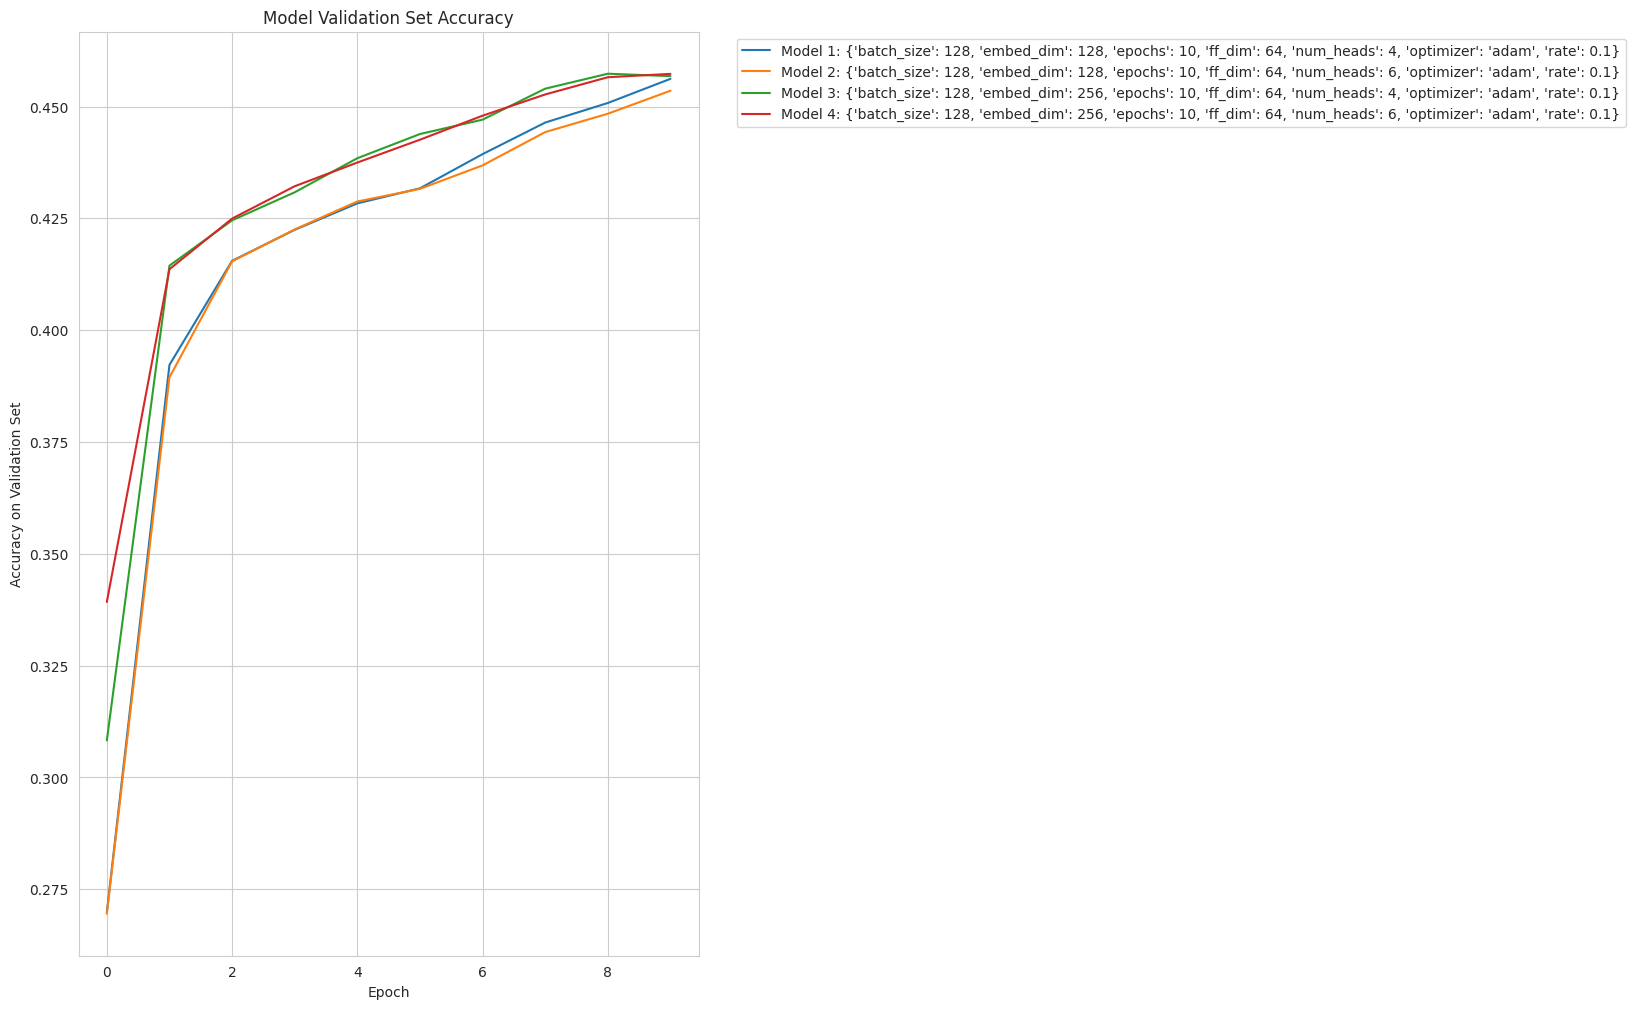

In [249]:
# Create a plot of accuracy over epochs
plt.figure(figsize=(8, 12))
for i, (history, config) in enumerate(zip(history_list, configs)):
    plt.plot(history["val_accuracy"], label=f"Model {i+1}: {config}")
plt.title("Model Validation Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy on Validation Set")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.grid(True)
plt.show()

/tmp/ipykernel_2067/1752565957.py:9: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


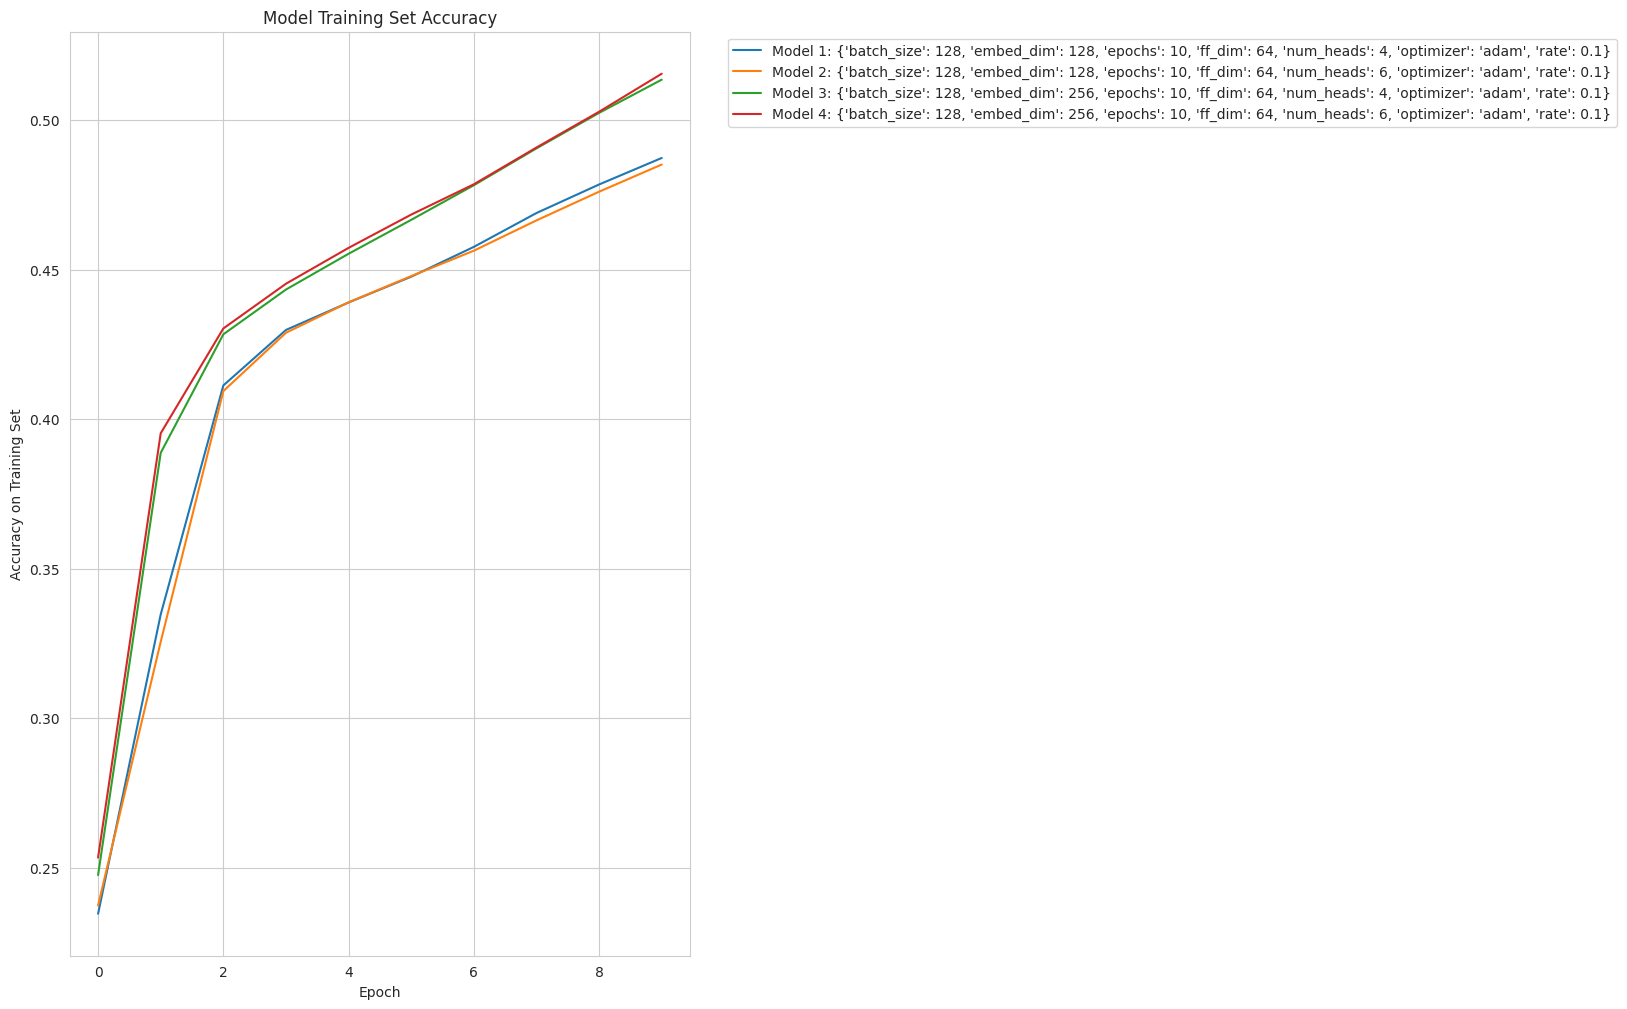

In [248]:
# Create a plot of accuracy over epochs
plt.figure(figsize=(8, 12))
for i, (history, config) in enumerate(zip(history_list, configs)):
    plt.plot(history["accuracy"], label=f"Model {i+1}: {config}")
plt.title("Model Training Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy on Training Set")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.grid(True)
plt.show()

### Examining Token Performance

Looking at overall accuracy gives us an idea of how well the model is doing. I also wanted to check how we were performing at a token level. Are there any tokens our model is really bad at predicting? Any where it is really good? In the past I have had models that are **outstanding** at predicting 'unknown' tokens, massively skewing the accuracy score. Lets investigate..

To examine token-level performance, I created two helper functions: `map_indices_to_tokens` and `plot_metrics`.

The `map_indices_to_tokens` function takes a classification report dictionary generated by scikit-learn's `classification_report` function and a tokenizer object. It maps the class indices in the report to their corresponding tokens using the tokenizer's `index_word` attribute. The function returns a pandas DataFrame where the index represents tokens and the columns represent metrics (precision, recall, f1-score, support).

The `plot_metrics` function takes the DataFrame generated by `map_indices_to_tokens`, along with the number of top tokens to display (`n`) and a minimum support threshold (`min_support`). It filters the tokens based on the minimum support value, selects the top `n` best-performing tokens by F1-score, and creates a 1x2 subplot. The first subplot displays a horizontal bar chart of the top `n` tokens and their F1-scores, while the second subplot shows the distribution of F1-scores for all tokens.

By using these functions, I can easily visualize and analyze the performance of individual tokens. 

I used the functions to create a plot of the top 40 tokens with at least 10 occurences in the dataset (n=40, min_support=10).


#### Individual token performance using F-1 Score

- I found it quite interesting that many of the tokens that we are good at classifying are the second part of common n-grams:
    - If we look at {first part} - {Predicted token} we have:
    - {Sauvignon} - {**Blanc**} ✅
    - {New} - {**Zealand**} ✅
    - {Pinot} - {**Grigio**} ✅
- In hindsight this is totally logical, these n grams appear very frequently in the texts and are 'easy' for th emodel to learn, even with our small sample of data.
- We also have the 'Unknown' token performing very well, this is to be expected. As I have not applied a padding token mask, the model will frequently have to predict empty parts of a sequence. This is not ideal, but unfortunately I couldn't get the causal mask and padding mask to work simultaneaously in the limited time. 

#### Plotting the distribution of F-1 Scores for all tokens
- We have thousands of tokens and it's not practical to examine them all.
- Instead I plotted the distribution of scores for all tokens.
- We can see that for the vase majority of tokens, our model is really bad 😭
    - This could be due to infrequent use of the tokens in our small dataset, so the model has few examples to learn from
    - It could be due to irregular word use or complex phrasing, which is inherently harder for the model to learn.
    - Due to time constraints, I didn't dig into this further. 
- I would expect this to change if we were to scale up the training to more data and more epochs (whilst carefully monitoring for overfitting).
- We do have quite a long right tail where we have a small number of words that we are able to classify well, such as the n-grams we mentioned earlier. This is a positive sign, and as we scaled up the training data size, I would expect to see this distribution to shift more mass to the right tail, becoming flatter and more left skewed as the mean F-1 score increases.


In [62]:
# Get predictions and evaluate performance on holdout set
y_pred = best_model.predict(X_val)

# Convert predictions to token indices
y_pred_indices = np.argmax(y_pred, axis=-1)
y_test_indices = np.argmax(y_val, axis=-1)

# Flatten the arrays for use in our plot functions..
y_pred_flat = y_pred_indices.flatten()
y_test_flat = y_test_indices.flatten()

# Calculate accuracy and other metrics
accuracy = accuracy_score(y_test_flat, y_pred_flat)
print(f"Overall Accuracy: {accuracy:.4f}")


def map_indices_to_tokens(classification_report_dict: dict, tokenizer) -> pd.DataFrame:
    """
    Map class indices to tokens in the classification report and convert the result into a DataFrame.

    Parameters
    ----------
    classification_report_dict : dict
        Classification report generated from sklearn, typically obtained using `classification_report(..., output_dict=True)`.
    tokenizer : Tokenizer
        Tokenizer object with `index_word` attribute used to map indices to tokens.

    Returns
    -------
    pd.DataFrame
        A DataFrame where the index represents tokens and columns represent metrics (precision, recall, f1-score, support).
    """
    # Initialize lists to hold the data for the DataFrame
    tokens = []
    precision = []
    recall = []
    f1_score = []
    support = []

    for class_index, metrics in classification_report_dict.items():
        if class_index.isdigit():  # Check if the key is a class index
            token = tokenizer.index_word.get(
                int(class_index), f"Unknown Token {class_index}"
            )
        else:
            # Skip the accuracy metrics
            continue

        # Append metrics to lists
        tokens.append(token)
        precision.append(metrics.get("precision", 0.0))
        recall.append(metrics.get("recall", 0.0))
        f1_score.append(metrics.get("f1-score", 0.0))
        support.append(metrics.get("support", 0))

    # Create DataFrame from lists
    df = pd.DataFrame(
        {
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1_score,
            "Support": support,
        },
        index=tokens,
    )

    return df


# Generate classification report as a dictionary
report_dict = classification_report(
    y_test_flat, y_pred_flat, output_dict=True, zero_division=0
)

# Map the indices to tokens and create a DataFrame
df_report = map_indices_to_tokens(report_dict, tokenizer)

display(df_report)

63/63 [==============================] - 3s 49ms/step
Overall Accuracy: 0.4616


,Precision,Recall,F1-Score,Support
Unknown Token 0,0.939685,0.995522,0.966798,27246.0
and,0.354673,0.705861,0.472121,5392.0
the,0.325250,0.546161,0.407704,3217.0
wine,0.256732,0.314483,0.282689,3183.0
a,0.218394,0.533333,0.309891,2805.0
...,...,...,...,...
redon's,0.000000,0.000000,0.000000,1.0
lirac,0.000000,0.000000,0.000000,1.0
specifically,0.000000,0.000000,0.000000,1.0
rosé—not,0.000000,0.000000,0.000000,1.0


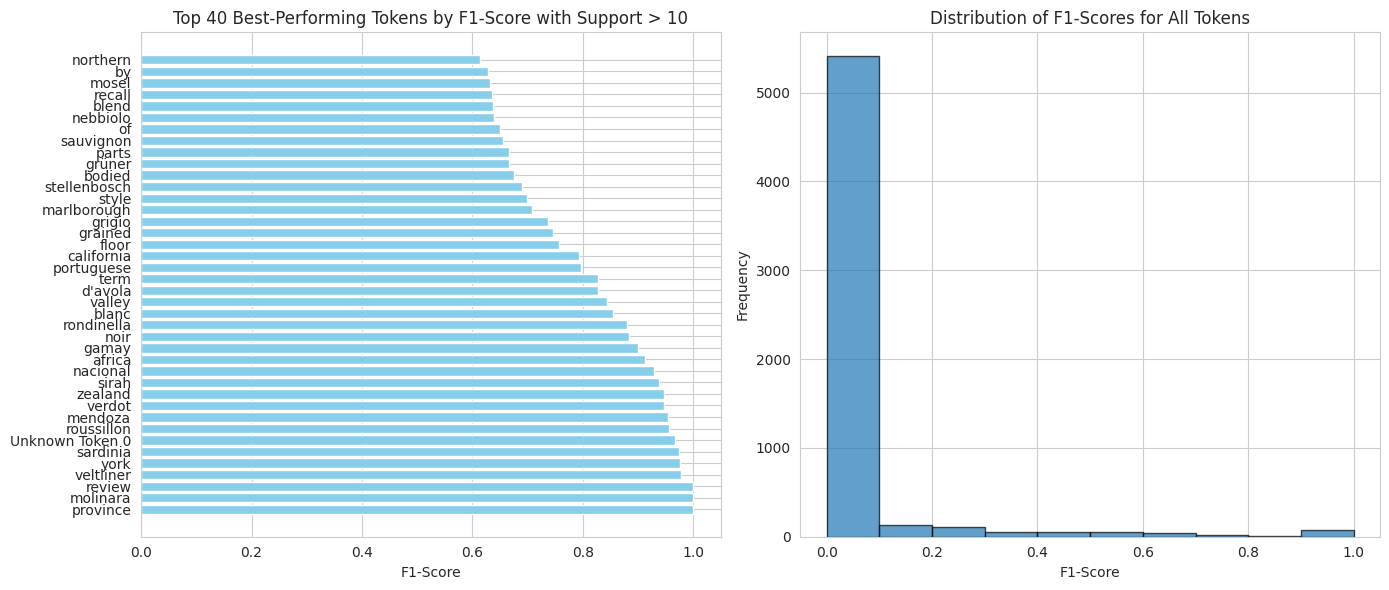

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def plot_metrics(df: pd.DataFrame, n: int, min_support: int):
    """
    Plots the top `n` best-performing tokens by F1-score and the distribution of F1-scores for all tokens.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing tokens and their metrics (Precision, Recall, F1-Score, Support).
    n : int
        Number of top tokens to select based on F1-score.
    min_support : int, optional
        Minimum support score to filter tokens. Only tokens with support greater than or equal to this value will be considered.
        Default is 0 (no filtering).
    """
    # Filter tokens based on the minimum support value
    filtered_df = df[df["Support"] >= min_support]

    # Sort filtered tokens by F1-Score and get top `n`
    top_n_df = filtered_df.sort_values(by="F1-Score", ascending=False).head(n)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), tight_layout=True)

    # Plot Top `n` Best-Performing Tokens
    axes[0].barh(top_n_df.index, top_n_df["F1-Score"], color="skyblue")
    axes[0].set_xlabel("F1-Score")
    axes[0].set_title(
        f"Top {n} Best-Performing Tokens by F1-Score with Support > {min_support}"
    )

    # Plot Distribution of F1-Scores for All Tokens
    axes[1].hist(
        df["F1-Score"], bins=np.arange(0, 1.1, 0.1), edgecolor="black", alpha=0.7
    )
    axes[1].set_xlabel("F1-Score")
    axes[1].set_ylabel("Frequency")
    axes[1].set_title("Distribution of F1-Scores for All Tokens")

    plt.show()


plot_metrics(df_report, n=40, min_support=10)

## Generate Text

Let's get the model to generate some text. I wrote another function to do this

The `generate_text` function generates new text using a trained model and a tokenizer. It takes the following parameters: `model` (trained model), `tokenizer` (text encoding/decoding), `seed_text` (initial input), `max_sequence_length` (maximum sequence length for training), and `num_generate` (number of tokens to generate, default=50).

The function starts by encoding the `seed_text` using the `tokenizer` and padding the sequences to `max_sequence_length-1`. It initializes the `generated_text` with the `seed_text`.

Then, it enters a loop that iterates `num_generate` times. In each iteration, it predicts the next token using `model.predict`, selects the token with the highest probability, and converts it back to its corresponding word using `tokenizer.index_word`. If no valid word is found, it breaks the loop. Otherwise, it appends the predicted word to the `generated_text` and updates the input sequence by converting the `generated_text` to sequences and padding it.


#### Using in domain seed sentences

```
seedtext = wine review : France : Alsace : Pinot Gris : A dry style wine with flavors

Generated Text:
wine review : France : Alsace : Pinot Gris : A dry style wine with flavors of minerality throughout dry tannins screwcap bottle aging flavors are refreshing and refreshing and refreshing acidity screwcap bottle age well
```

```
seed_text = "wine review : Portugal : Douro : Portuguese Red : This is ripe and fruity"

Generated Text:
 wine review : Portugal : Douro : Portuguese Red : This is ripe and fruity wine now screwcap bottle aging has a touch of spice flavors screwcap bottle aging potential drink now screwcap bottle age
```

We can see that the model very quickly starts generating 'screwcap bottle' repeatedly and other nonsense which is not ideal. 
Generally from experimentation, the model is able to generate a valid next or next + 1 word after the seed which is not bad considering how little data we used to train it. 



#### Using out of domain seed sentences

We have used a very specific corpus of wine reviews to train our model (and not many of them to boot). If we try and give the model an out of domain seed sentence, we would expect to see it generate nonsense and this is exactly what happens.

Due to the narrow training data, our model is completely unable to predict for any seed sentence that is not wine related. To achieve performance on out of domain sentences, we would need a much larger generalised text corpus.

```
seed_text = "The cat sat on the"

Generated Text:
 The cat sat on the finish finish screwcap bottle age years screwcap bottle age years screwcap bottle age years screwcap bottle age years screwcap bottle
```







In [59]:
def generate_text(
    model: tf.keras.Model,
    tokenizer: tf.keras.preprocessing.text.Tokenizer,
    seed_text: str,
    max_sequence_length: int,
    num_generate: int = 50,
) -> str:
    """
    Generate text from a seed input using the trained model.

    Parameters
    ----------
    model : tf.keras.Model
        The trained model.
    tokenizer : tf.keras.preprocessing.text.Tokenizer
        The tokenizer used for encoding and decoding text.
    seed_text : str
        The initial text input to start generation.
    max_sequence_length : int
        The maximum length of sequences used for training.
    num_generate : int, optional
        Number of tokens to generate (default is 50).

    Returns
    -------
    str
        Generated text.
    """
    # Encode the seed text
    sequences = tokenizer.texts_to_sequences([seed_text])
    padded_sequences = pad_sequences(
        sequences, maxlen=max_sequence_length - 1, padding="pre"
    )

    generated_text = seed_text
    print(f"Initial padded sequence: {padded_sequences}")

    for _ in range(num_generate):
        # Predict the next token
        predictions = model.predict(padded_sequences)
        predicted_token_index = np.argmax(predictions[0, -1, :])

        # Debugging output
        # print(f"Predicted token index: {predicted_token_index}")
        # print(f"Predicted probabilities: {predictions[0, -1, :]}")

        # Convert token index to word
        predicted_word = tokenizer.index_word.get(predicted_token_index, None)
        if predicted_word is None:
            print("No valid predicted word found.")
            break

        # Append the predicted word to the generated text
        generated_text += " " + predicted_word

        # Update the input sequence
        new_sequence = tokenizer.texts_to_sequences([generated_text])
        padded_sequences = pad_sequences(
            new_sequence, maxlen=max_sequence_length - 1, padding="pre"
        )

    return generated_text

In [79]:
seed_text = "wine review : France : Alsace : Pinot Gris : A dry style wine with flavors"
generated_text = generate_text(
    best_model, tokenizer, seed_text, max_sequence_length, num_generate=20
)

print("Generated Text:\n", generated_text)

Initial padded sequence: [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   3   6  34 426  38 383
    4  52  57   3   7  10]]
1/1 [==============================] - 0s 21ms/step
Generated Text:
 wine review : France : Alsace : Pinot Gris : A dry style wine with flavors of minerality throughout dry tannins screwcap bottle aging flavors are refreshing and refreshing and refreshing acidity screwcap bottle age well


In [76]:
seed_text = "wine review : Portugal : Douro : Portuguese Red : This is ripe and fruity"

generated_text = generate_text(
    model, tokenizer, seed_text, max_sequence_length, num_generate=20
)

print("Generated Text:\n", generated_text)

Initial padded sequence: [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   3   6 150 468 219
   17   8   9  31   1  88]]
1/1 [==============================] - 0s 21ms/step
Generated Text:
 wine review : Portugal : Douro : Portuguese Red : This is ripe and fruity wine now screwcap bottle aging has a touch of spice flavors screwcap bottle aging potential drink now screwcap bottle age


In [28]:
# Using a random, out of domain seed to trick the model
seed_text = "The cat sat on the"

generated_text = generate_text(
    model, tokenizer, seed_text, max_sequence_length, num_generate=20
)

print("Generated Text:\n", generated_text)

Initial padded sequence: [[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     2 10381    16     2]]
1/1 [==============================] - 0s 10ms/step
Generated Text:
 The cat sat on the finish finish screwcap bottle age years screwcap bottle age years screwcap bottle age years screwcap bottle age years screwcap bottle


predictions

## What could be done to improve the accuracy and robustness of the model?


While the initial results from our simple transformer model are OK, there is clearly a lot of room for improvement. Here are some steps I might take to improve this model.

### More Data, More Epochs!

- Our model was trained on a very small subset of the available data and for a very small number of epochs. This was done to keep training times short and allow me to do this locally on my laptop.
- By increasing the size of the training dataset, we can provide the model with more diverse examples and improve its ability to learn meaningful patterns. This is particularly important for handling rare or complex tokens that may not appear frequently in a small dataset as we started to demonstrate by looking at the scores for individual tokens.
- Additionally, experimenting with more epochs while carefully monitoring for overfitting can allow the models to learn more effectively. We saw that the models' validation accuracy consistently improved with more epochs and seemed to be still increasing after 10, so it would be interesting to see how far we can push this before overfitting becomes a concern.

### Hyperparameter Tuning

- We performed a small grid search over a limited set of hyperparameters, such as embedding dimensions and attention heads.
- While this provided some insights, to truly optimize the model's performance, we need to expand the search space and investigate the impact of different hyperparameter configurations more thoroughly.
- This could involve exploring a wider range of embedding dimensions, attention heads, dropout rates, and other architectural choices like adding more layers.

### Improved Text Generation

- Our current text generation function uses a simple approach of selecting the token with the highest probability at each step.
- While this works to some extent, it can often lead to repetitive or nonsensical output, as we observed in our experiments.
- To generate more coherent and diverse text, we can explore different decoding strategies, such as beam search or top-k sampling.
- Beam search considers multiple sequences simultaneously and selects the best one based on a scoring function, which can help generate more fluent and contextually relevant text.
- Top-k sampling randomly samples from the top k most probable tokens at each step, introducing some randomness and diversity into the generated text which might prevent the repetition we saw towards the end of our generated responses. 

### Transfer Learning and Pre-training

- Our model was trained from scratch on a relatively small dataset, which limits its ability to capture broad linguistic knowledge and generalize to out-of-domain tasks.
- To overcome this limitation, we can leverage transfer learning and pre-training techniques.
- This could involve fine-tuning and existing model on our dataset using either full fine tuning or less intensive techniques like low rank adaptation (LORA) or QLORA. This would allow us to leverage the vast, generalised pre-training of other LLM's as well as their complex architectures.
- If we were set on training our own model from scratch, we could instead utilise a pre-trained embedding model in our embedding layer. This would similarly allow us to benefit from comprehensive pre-training in our text representations but also allow us to train the later layers ourselves. 

### Further Analysis and Interpretation

- While we performed some analysis of token-level performance using F1-scores, there is still much more we can explore to gain deeper insights into the model's behavior.
- We could evaluate more LLM specific metrics such as perplexity(PPL). PPL quantifies the uncertainty or confusion of a language model when predicting the next word in a sequence. A lower perplexity value shows that the model is more confident and accurate in its predictions, while a higher perplexity value suggests that the model is more uncertain or confused. Our model is likely not good enough to bother at the moment! 
- I would particularly like to examine the behaviour of the model on infrequent tokens further, evaluating the impact of scaling up the training data. 
- We can also investigate the attention patterns learned by the model to understand how it is attending to different parts of the input sequence and what relationships it is capturing.
- Visualizing the embeddings learned by the model can provide insights into how it is representing and structuring the input data. We could examine things like similarity scores between pairs of very similar texts. We can also assess their stability whilst training, which may help us identify when the model is converging.

### Code structure

- I have tried to lay out the code as I would in a real project, using complete functions and classes.
- I have used pip-tools and makefile commands to manage dependencies and create a compatible environment, which makes handing over code extremely easy. Anyone with Conda can take the code, run `make create_environment` and then run the notebook. 
- I always like to use comprehensive docstrings and type hinting, I find it helps with readability and handover of code.
- In practice, If I were writing functions and classess like this they would be placed into a python file and imported into the notebook. I would also use a logical structure eg: `model_layers.py`, `model_build.py`, `text_processing.py` etc.
- I generally like to unit test any funciton that has some logic that may go wrong. I think well tested code gives you lots of confidence in your results. 

In conclusion, while our initial transformer model was able to generate some text, it didn't do it very well which is to be expected given the constraints of the task. 




# Task 2

Again, there are some options of how you may want to lay out your work below but feel free to put it into a format that you think is best. The data in the health folder is split into raw and final. We suggest first looking at the raw data and then the final test and train in your exploration. If you want more context regarding the data there is information in the papers folder that tells you where this data is from.





# Analysis


The 2019 paper describes the dataset as the result of collecting physiological data from over 25 test subjects whilst they conducted normal office work. The researchers exposed the test subjects to typical 'working stressors' such as receiving unexpected emails, interruptions and increased pressure to complete work to a deadline. The data recorded includes physiological data relating to heart rate, facial expressions, body postures, computer interactions as well as others. It appears the dataset we is from the latter paper, which focusses purely on Heart Rate variability. 

The working stressors are categorized as:

1. No Stress
2. Time Pressure
3. Interruption


Given these classes, I will imagine a hypothetical scenario where we want to create a classification model to classify the above states given the available heart rate features. We will therefore attempt to examine the relationship between these features and the given classes and make recommendations on how we might tackle feature selection.


In [237]:
import os

import numpy as np
# imports here so I don't have scroll all the way up again..
import pandas as pd
from scipy.stats import chi2_contingency

pd.set_option("display.max_columns", None)

### Load Raw Data

- The brief mentions loading the raw data first to examine it, then proceeding to the prepared csv files.
- There are 23 .txt files, with number 'p8.txt and p11.txt' are missing which would suggest that one file represents a single test subject. 
- The raw text files seem to contain a pair of raw features.
- It's not immediately clear what these are but by plotting a scatter plot, we might assume that:
    - The first column represents time as it linearly increases
    - The second column represents some heart related feature given the context from the paper.
- The excel file seems to contain our labels, some heart rate information and some other features with time stamps.
- It's not immediately obvious how the final datasets were constructed from this data but let's take a look at them next.

In [161]:
# Paths - not I had to remove the spaces to get this to work if you would like to re-run it.
# Specify the path to the Excel file
raw_labels_path = "data/health/Exercice_Classification_du_stress/data/raw/labels/hrv_stress_labels.xlsx"
raw_txt_path_p1 = "data/health/Exercice_Classification_du_stress/data/raw/rri/p1.txt"
raw_txt_path_p12 = "data/health/Exercice_Classification_du_stress/data/raw/rri/p12.txt"

In [162]:
raw_text_p1 = np.loadtxt(raw_txt_path_p1)
raw_text_p12 = np.loadtxt(raw_txt_path_p12)
# Display the loaded data
print(raw_text_p1)
print(len(raw_text_p1))
print(len(raw_text_p12))

[[1.2656250e+00 8.7011719e+02]
 [1.5156250e+00 8.8536996e+02]
 [1.7656250e+00 8.9018974e+02]
 ...
 [8.9940156e+03 8.9307964e+02]
 [8.9942656e+03 8.7889905e+02]
 [8.9945156e+03 8.7108091e+02]]
35974
34395


In [163]:
# Specify the directory path where the text files are located
directory_path = "data/health/Exercice_Classification_du_stress/data/raw/rri"

# Initialize an empty list to store the data from all files
data = []

# Loop through files p1.txt to p25.txt
for i in range(1, 26):
    file_name = f"p{i}.txt"
    file_path = os.path.join(directory_path, file_name)

    # Load the data from the text file
    try:
        file_data = pd.read_csv(
            file_path, header=None, sep=r"\s+", names=["column1", "column2"]
        )

        # Add a new column to indicate the file number
        file_data["file_number"] = i
    except FileNotFoundError:
        logger.warning(f"Could not find file {file_path}")
        continue

    # Append the data to the list
    data.append(file_data)

# Concatenate all the data into a single DataFrame
df = pd.concat(data, ignore_index=True)

# Display the first few rows of the DataFrame
display(df)

2024-07-24 11:43:17.013 | WARNING  | __main__:<module>:19 - Could not find file data/health/Exercice_Classification_du_stress/data/raw/rri/p8.txt
2024-07-24 11:43:17.036 | WARNING  | __main__:<module>:19 - Could not find file data/health/Exercice_Classification_du_stress/data/raw/rri/p11.txt


,column1,column2,file_number
0,1.265625,870.11719,1
1,1.515625,885.36996,1
2,1.765625,890.18974,1
3,2.015625,886.73851,1
4,2.265625,877.17820,1
...,...,...,...
704449,6127.709000,649.97049,25
704450,6127.959000,649.61457,25
704451,6128.209000,646.93449,25
704452,6128.459000,638.73799,25


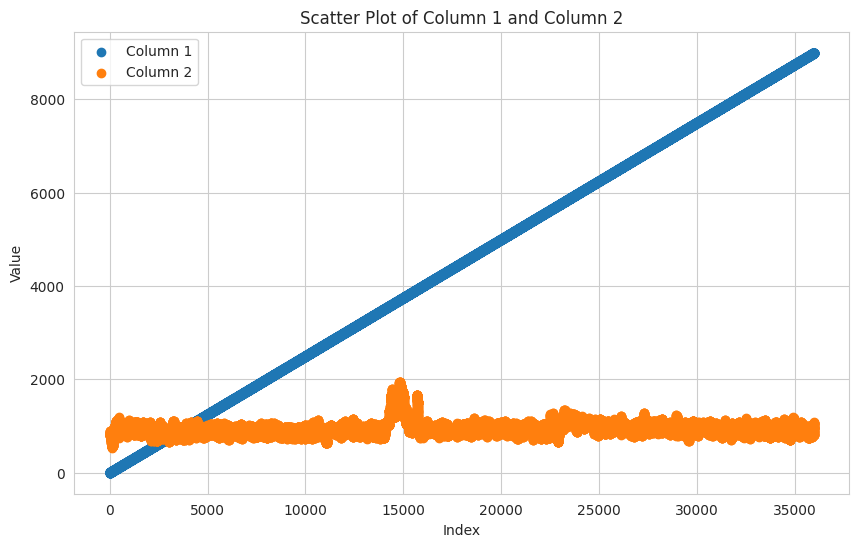

In [164]:
# Filter the DataFrame for file_number equal to 1
filtered_df = df[df["file_number"] == 1]

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_df.index, filtered_df["column1"], label="Column 1")
plt.scatter(filtered_df.index, filtered_df["column2"], label="Column 2")

# Set labels and title
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Scatter Plot of Column 1 and Column 2")

# Add legend
plt.legend()

# Display the plot
plt.show()

In [165]:
# Load the Excel file into a pandas DataFrame
raw_labels = pd.read_excel(raw_labels_path)

# Display the loaded data
raw_labels.head()

,Unnamed: 0,PP,C,timestamp,HR,RMSSD,SCL,date,subject,label,Condition,ElapsedTime
0,0,PP1,1,20120918T131600000,NaN,NaN,80.239727,2012-09-18 13:16:00,p1,rest,R,0
1,1,PP1,1,20120918T131700000,61.0,0.061420,77.365127,2012-09-18 13:17:00,p1,rest,R,1
2,2,PP1,1,20120918T131800000,64.0,0.049663,77.359559,2012-09-18 13:18:00,p1,rest,R,2
3,3,PP1,1,20120918T131900000,60.0,0.052487,76.728772,2012-09-18 13:19:00,p1,rest,R,3
4,4,PP1,1,20120918T132000000,61.0,0.051189,76.512877,2012-09-18 13:20:00,p1,rest,R,4


## Loading the CSV Datasets

- The train and test datasets appear to contain the same 36 features
- From scanning the 2019 paper it appears we have many calculated features based on the heart rate information particularly:
    -  RR_interval (Time between spikes on cardiogram) we have mean, median, stdev, RMS, kurtosis etc...


In [166]:
train = pd.read_csv(
    "data/health/Exercice_Classification_du_stress/data/final/train.csv"
)

test = pd.read_csv("data/health/Exercice_Classification_du_stress/data/final/test.csv")

In [167]:
assert all(train.columns) == all(test.columns)
print(train.columns)
display(train)
display(test)

Index(['MEAN_RR', 'MEDIAN_RR', 'SDRR', 'RMSSD', 'SDSD', 'SDRR_RMSSD', 'HR',
       'pNN25', 'pNN50', 'SD1', 'SD2', 'KURT', 'SKEW', 'MEAN_REL_RR',
       'MEDIAN_REL_RR', 'SDRR_REL_RR', 'RMSSD_REL_RR', 'SDSD_REL_RR',
       'SDRR_RMSSD_REL_RR', 'KURT_REL_RR', 'SKEW_REL_RR', 'VLF', 'VLF_PCT',
       'LF', 'LF_PCT', 'LF_NU', 'HF', 'HF_PCT', 'HF_NU', 'TP', 'LF_HF',
       'HF_LF', 'sampen', 'higuci', 'datasetId', 'condition'],
      dtype='object')


,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,HR,pNN25,pNN50,SD1,SD2,KURT,SKEW,MEAN_REL_RR,MEDIAN_REL_RR,SDRR_REL_RR,RMSSD_REL_RR,SDSD_REL_RR,SDRR_RMSSD_REL_RR,KURT_REL_RR,SKEW_REL_RR,VLF,VLF_PCT,LF,LF_PCT,LF_NU,HF,HF_PCT,HF_NU,TP,LF_HF,HF_LF,sampen,higuci,datasetId,condition
0,885.157845,853.763730,140.972741,15.554505,15.553371,9.063146,69.499952,11.133333,0.533333,11.001565,199.061782,-0.856554,0.335218,-0.000203,-0.000179,0.017080,0.007969,0.007969,2.143342,-0.856554,0.335218,2661.894136,72.203287,1009.249419,27.375666,98.485263,15.522603,0.421047,1.514737,3686.666157,65.018055,0.015380,2.139754,1.163485,2,no stress
1,939.425371,948.357865,81.317742,12.964439,12.964195,6.272369,64.363150,5.600000,0.000000,9.170129,114.634458,-0.408190,-0.155286,-0.000059,0.000611,0.013978,0.004769,0.004769,2.930855,-0.408190,-0.155286,2314.265450,76.975728,690.113275,22.954139,99.695397,2.108525,0.070133,0.304603,3006.487251,327.296635,0.003055,2.174499,1.084711,2,interruption
2,898.186047,907.006860,84.497236,16.305279,16.305274,5.182201,67.450066,13.066667,0.200000,11.533417,118.939253,0.351789,-0.656813,-0.000011,-0.000263,0.018539,0.008716,0.008716,2.127053,0.351789,-0.656813,1373.887112,51.152225,1298.222619,48.335104,98.950472,13.769729,0.512671,1.049528,2685.879461,94.280910,0.010607,2.135350,1.176315,2,interruption
3,881.757865,893.460030,90.370537,15.720468,15.720068,5.748591,68.809562,11.800000,0.133333,11.119476,127.318597,-0.504947,-0.386138,0.000112,0.000494,0.017761,0.008660,0.008660,2.050988,-0.504947,-0.386138,2410.357408,70.180308,1005.981659,29.290305,98.224706,18.181913,0.529387,1.775294,3434.520980,55.328701,0.018074,2.178341,1.179688,2,no stress
4,809.625331,811.184865,62.766242,19.213819,19.213657,3.266724,74.565728,20.200000,0.200000,13.590641,87.718281,-0.548408,-0.154252,-0.000100,-0.002736,0.023715,0.013055,0.013055,1.816544,-0.548408,-0.154252,1151.177330,43.918366,1421.782051,54.242160,96.720007,48.215822,1.839473,3.279993,2621.175204,29.487873,0.033912,2.221121,1.249612,2,no stress
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369284,721.396910,721.533965,36.377559,9.609941,9.609936,3.785409,83.384647,0.933333,0.000000,6.797519,50.994582,1.007321,0.075965,0.000015,0.000083,0.013352,0.008732,0.008732,1.529068,1.007321,0.075965,298.009244,45.893349,313.115284,48.219676,89.119683,38.227175,5.886975,10.880317,649.351702,8.190908,0.122087,2.096850,1.314910,2,no stress
369285,984.266492,978.622945,74.918433,13.762274,13.761705,5.443754,61.314243,6.333333,0.200000,9.734243,105.502548,0.248964,0.167716,-0.000110,0.000046,0.014014,0.006317,0.006317,2.218313,0.248964,0.167716,1558.597883,68.405858,717.285030,31.481178,99.642453,2.573834,0.112964,0.357547,2278.456746,278.683532,0.003588,2.131264,1.175975,2,no stress
369286,1025.499743,1024.968400,95.309200,23.051254,23.050395,4.134664,59.028594,30.400000,2.066667,16.304530,133.797793,-0.429686,-0.075321,-0.000216,-0.002236,0.022705,0.009494,0.009494,2.391601,-0.429686,-0.075321,1950.393956,45.030641,2376.578392,54.870376,99.819930,4.287216,0.098983,0.180070,4331.259564,554.340761,0.001804,2.215643,1.140232,2,no stress
369287,798.123167,803.559610,78.449897,16.736686,16.736657,4.687302,75.978628,10.000000,1.466667,11.838553,110.311474,0.600389,-0.634762,0.000024,-0.001354,0.021549,0.011376,0.011376,1.894304,0.600389,-0.634762,1606.291482,54.821185,1277.128490,43.587168,96.477005,46.636158,1.591647,3.522995,2930.056129,27.384942,0.036516,2.091628,1.181937,2,no stress


,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,HR,pNN25,pNN50,SD1,SD2,KURT,SKEW,MEAN_REL_RR,MEDIAN_REL_RR,SDRR_REL_RR,RMSSD_REL_RR,SDSD_REL_RR,SDRR_RMSSD_REL_RR,KURT_REL_RR,SKEW_REL_RR,VLF,VLF_PCT,LF,LF_PCT,LF_NU,HF,HF_PCT,HF_NU,TP,LF_HF,HF_LF,sampen,higuci,datasetId,condition
0,721.901897,727.267280,74.722315,12.361264,12.361069,6.044877,84.121868,4.933333,0.000000,8.743513,105.310967,1.262958,-0.703779,0.000081,-0.000951,0.017605,0.011208,0.011208,1.570800,1.262958,-0.703779,1016.073759,59.818117,615.914573,36.260015,90.239711,66.617057,3.921868,9.760289,1698.605390,9.245599,0.108160,2.097342,1.243696,2,no stress
1,843.538633,844.407930,58.499429,19.298880,19.298795,3.031234,71.478642,21.000000,0.200000,13.650863,81.596693,-0.445806,-0.144911,0.000061,-0.001543,0.022969,0.011970,0.011970,1.918953,-0.445806,-0.144911,765.518473,32.452560,1566.866135,66.424024,98.336849,26.500086,1.123416,1.663151,2358.884694,59.126832,0.016913,2.217275,1.250056,2,time pressure
2,958.523868,966.671125,132.849110,21.342715,21.342653,6.224565,63.874293,24.133333,1.800000,15.096571,187.269500,-0.666523,-0.103725,-0.000055,-0.002000,0.022079,0.009606,0.009606,2.298473,-0.666523,-0.103725,2237.739905,51.696218,2074.868884,47.933575,99.233584,16.024935,0.370208,0.766416,4328.633724,129.477524,0.007723,2.217136,1.144943,2,no stress
3,824.838669,842.485905,117.822094,11.771814,11.771248,10.008830,74.330531,4.733333,0.533333,8.326307,166.417439,-0.698096,-0.145092,0.000130,0.000445,0.014920,0.007051,0.007051,2.116033,-0.698096,-0.145092,2330.980957,81.661325,505.886664,17.722743,96.641348,17.581470,0.615932,3.358652,2854.449091,28.773854,0.034754,2.106863,1.142355,2,no stress
4,756.707933,747.941620,143.968457,13.357748,13.356388,10.777899,82.092049,5.933333,0.666667,9.447545,203.382835,1.134111,0.769517,0.000310,-0.000170,0.019649,0.011689,0.011689,1.681034,1.134111,0.769517,4750.624447,89.465158,524.203971,9.871963,93.707747,35.199054,0.662879,6.292253,5310.027472,14.892559,0.067148,1.912191,1.128098,2,interruption
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41028,1118.406543,1117.857050,113.955632,18.592177,18.592071,6.129225,54.234182,18.800000,0.266667,13.150967,160.620124,0.039637,-0.168160,0.000053,-0.000785,0.017038,0.005512,0.005512,3.091047,0.039637,-0.168160,4130.820437,80.985074,969.550262,19.008113,99.964170,0.347514,0.006813,0.035830,5100.718213,2789.962965,0.000358,2.183460,1.082927,2,time pressure
41029,855.991173,765.221410,296.763366,20.623727,20.610745,14.389415,76.416971,15.733333,3.533333,14.578861,419.433484,3.644498,1.866897,0.000736,0.000847,0.028135,0.016151,0.016151,1.742060,3.644498,1.866897,7163.989622,83.960222,1250.595884,14.656681,91.377081,118.014128,1.383097,8.622919,8532.599635,10.597001,0.094366,1.695327,1.154370,2,interruption
41030,689.388662,663.192770,133.815714,21.699038,21.696138,6.166896,90.254005,13.933333,4.000000,15.346606,188.620710,0.885293,0.689171,-0.000329,0.000709,0.032607,0.019102,0.019102,1.706976,0.885293,0.689171,3946.374071,64.968893,1911.676588,31.471804,89.839595,216.200973,3.559302,10.160405,6074.251632,8.842128,0.113095,2.078000,1.214869,2,no stress
41031,761.421571,761.064590,60.792671,11.280586,11.280573,5.389141,79.313782,2.733333,0.266667,7.979232,85.602742,0.005286,-0.040367,-0.000021,-0.000300,0.015049,0.008822,0.008822,1.705789,0.005286,-0.040367,732.516968,54.756129,563.466628,42.119504,93.094387,41.797177,3.124367,6.905613,1337.780773,13.480973,0.074179,2.191379,1.234546,2,no stress


## Comparing Train and Test Sets

If we want to train a supervised model, we must make sure our train and test data share the same distributions of features and classes: What the model sees in training should reflect what it will see in unseen data also. 

- Firstly I decided to check the proportion of each class in the respective sets. **There are equal proportions of each class in train/test**
- Next I checked the distribution of all of the component features across both datasets was approximately equal and the visual fit is very good for all features.
- The train test split looks valid and appears to be suitable for use.


We could go ahead and combine the datasets to perform further analysis and this may give us slightly more reliable results, but as we have seen that they are very representative of one another, I will proceed with the test set just to speed up computations. 


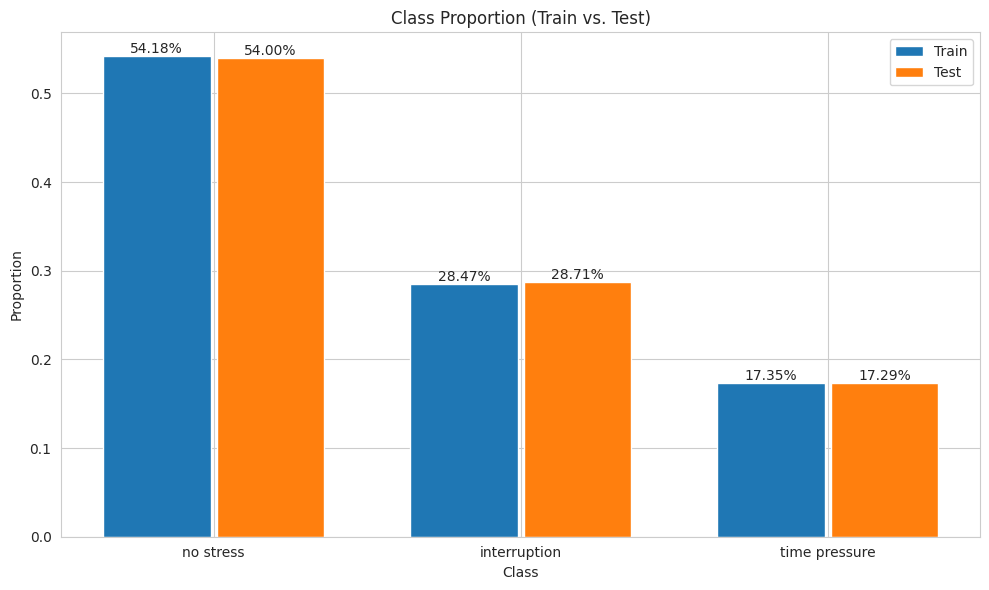

In [148]:
# Calculate the proportion of each class in the 'condition' column for train and test DataFrames
train_class_props = train["condition"].value_counts(normalize=True)
test_class_props = test["condition"].value_counts(normalize=True)

# Get the unique class labels
classes = train_class_props.index

bar_width = 0.35
spacing = 0.02

fig, ax = plt.subplots(figsize=(10, 6))

# Create the bars for train and test DataFrames
train_bars = ax.bar(
    range(len(classes)), train_class_props.values, bar_width, label="Train"
)
test_bars = ax.bar(
    [x + bar_width + spacing for x in range(len(classes))],
    test_class_props.values,
    bar_width,
    label="Test",
)

# Set the x-tick labels and positions
ax.set_xticks([x + bar_width / 2 + spacing / 2 for x in range(len(classes))])
ax.set_xticklabels(classes)

ax.set_xlabel("Class")
ax.set_ylabel("Proportion")
ax.set_title("Class Proportion (Train vs. Test)")

# Add percentage labels to the bars
for bar in train_bars + test_bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.2%}",
        ha="center",
        va="bottom",
    )

ax.legend()

plt.tight_layout()
plt.show()

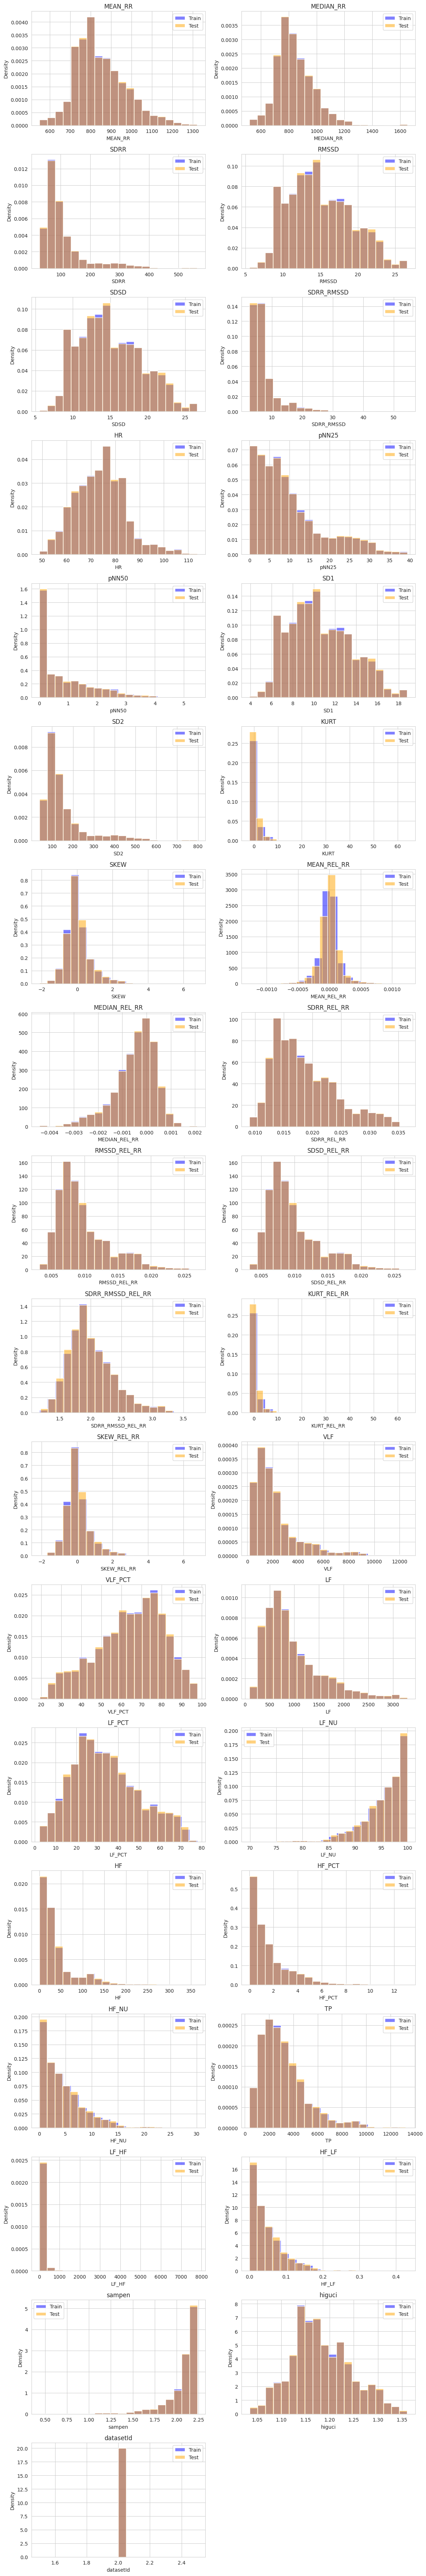

In [187]:
# Select the numerical features from the train and test DataFrames
train_numeric = train.select_dtypes(include=["float64", "int64"])
test_numeric = test.select_dtypes(include=["float64", "int64"])

numerical_columns = train_numeric.columns

# Create subplots for each numerical column
num_columns = len(numerical_columns)
num_rows = (num_columns + 1) // 2  # Calculate the number of rows needed
fig, axes = plt.subplots(num_rows, 2, figsize=(12, num_rows * 4))
axes = axes.flatten()

for i, column in enumerate(numerical_columns):
    ax = axes[i]
    sns.histplot(
        train_numeric[column],
        stat="density",
        ax=ax,
        color="blue",
        alpha=0.5,
        bins=20,
        label="Train",
    )
    sns.histplot(
        test_numeric[column],
        stat="density",
        ax=ax,
        color="orange",
        alpha=0.5,
        bins=20,
        label="Test",
    )
    ax.set_title(column)
    ax.legend()

# Remove any unused subplots
for i in range(num_columns, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

## Feature Correlations & Scales


### Feature Scales

- Using df.describe it's clear we have wildly varying feature scales, which is problematic for any distance based methods (eg SVMs) or methods that rely on gradient descent (eg NNs).
    - This can cause over-influence of features with large scales, disproportionate to their impact on the prediction.
    - In gradient descent, large differences in feature scales will cause varying gradient magnitudes that will slow the training process or lead to a sub-optimal solution.

**Recommendations**
- We could mitigate this issue simply by using a model that is invariant to feature scales: Tree based methods can work well.
- Alternatively, we would need to look at some kind of feature scaling like Z-score normalisation or min-max scaling, the choice of which depends on our model and the specific feature.
- **Any scaling applied to the dataset should be done using training data only, including test data in the scaling calculations may introduce data leakage**


#### Correlations

We also have a small number of both highly  positively and negatively correlated features in the dataset. This may be expected due to the nature of these calculate features that are essentially descriptive statistics of one of the features.
- Highly positively correlated features can introduce redundancy into the feature space, the variation in both features can be largely explained by one or the other without losing any signal to our model.
- Again if we were planning to use any kind of distance based model for classification, Logistic Regression or SVM's for example, this multicolinearity may cause instability in the coefficients and reduce performance.

**Recommendations**
- The strong correlations in our dataset suggests a lot of redundancy in the available features. In practice I'd employ a few feature selection processes by:
    - Scanning the correlation matrix columns and look for consistent correlations between features across all other features.
        - In theory, features like `Mean_RR` and `Median_RR` or `RMSSD` and `SSD` or `RMSSD_REL_RR` and `SSD_REL_RR` should be interchangable, all of their correlations with other features are extremely close.
    - Other highly correlated features like `HF PCT` and `HF NU` are less clear cut, and though they are highly correlated with one another, their correlations with the rest of the feature set vary wildly, indicated they have some signal for our model. 
    - Building domain knowledge/working with domain experts to identify features that had a high likelihood of being valuable based on prior knowledge eg: high stress events are associated with high heart rate therefore keep heart rate.
- If we were using a tree based method, we can calculate feature importances natively and use them to guide feature selection. 
- In addition to or instead of feature selection we could employ some kind of dimensionality reduction technique like PCA or SVD. Both of these techniques create new features 'principal components' that capture the variance in the dataset and eliminate any correlations.
- Finally, if we have solid reasons to include highly correlated features then we could use L1 or L2 regularisation to reduce the impact of these high correlations. 



In [189]:
test.describe()

,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,HR,pNN25,pNN50,SD1,SD2,KURT,SKEW,MEAN_REL_RR,MEDIAN_REL_RR,SDRR_REL_RR,RMSSD_REL_RR,SDSD_REL_RR,SDRR_RMSSD_REL_RR,KURT_REL_RR,SKEW_REL_RR,VLF,VLF_PCT,LF,LF_PCT,LF_NU,HF,HF_PCT,HF_NU,TP,LF_HF,HF_LF,sampen,higuci,datasetId
count,41033.000000,41033.000000,41033.000000,41033.000000,41033.000000,41033.000000,41033.000000,41033.000000,41033.000000,41033.000000,41033.000000,41033.000000,41033.000000,4.103300e+04,41033.000000,41033.000000,41033.000000,41033.000000,41033.000000,41033.000000,41033.000000,41033.000000,41033.000000,41033.000000,41033.000000,41033.000000,41033.000000,41033.000000,41033.000000,41033.000000,41033.000000,41033.000000,41033.000000,41033.000000,41033.0
mean,846.856304,842.112932,108.856642,14.989588,14.988858,7.369326,73.899319,9.888347,0.862545,10.602260,153.475051,0.520719,0.044934,-2.872766e-08,-0.000468,0.018561,0.009690,0.009690,2.008090,0.520719,0.044934,2196.457487,64.221039,948.851848,34.168102,95.586613,39.012113,1.610860,4.413387,3184.321449,117.181622,0.048261,2.063608,1.182641,2.0
std,124.422504,131.976225,76.602112,4.139121,4.139143,5.146460,10.320644,8.262497,0.986774,2.927793,108.442308,1.791907,0.694370,1.620372e-04,0.000865,0.005451,0.003886,0.003886,0.377263,1.791907,0.694370,1815.262687,16.838147,577.413541,16.105461,4.102133,44.994281,1.750709,4.102133,1923.544936,368.039153,0.048859,0.207427,0.062489,0.0
min,547.483802,517.293295,27.338606,5.531588,5.531493,2.664721,48.736986,0.000000,0.000000,3.912661,38.454442,-1.894831,-2.136234,-1.275240e-03,-0.004425,0.008987,0.003220,0.003220,1.186548,-1.894831,-2.136234,160.869730,19.301549,92.663980,2.163917,70.682584,0.062809,0.002211,0.012971,378.053805,2.410942,0.000130,0.435664,1.034420,2.0
25%,760.387193,755.686825,64.132798,11.833717,11.833463,4.517620,66.633381,3.600000,0.000000,8.370315,90.236880,-0.352526,-0.351531,-7.011447e-05,-0.000919,0.014237,0.006972,0.006972,1.751317,-0.352526,-0.351531,994.970318,52.721914,544.688588,22.299698,93.659224,10.551975,0.338246,1.205268,1820.982721,14.770940,0.012200,2.034956,1.140058,2.0
50%,822.611612,819.624875,82.710729,14.431598,14.431425,5.934226,74.219199,7.600000,0.466667,10.207964,116.339025,0.039643,-0.053997,2.305116e-07,-0.000312,0.017305,0.008698,0.008698,1.935984,0.039643,-0.053997,1665.049572,66.240263,783.452494,32.171726,96.658088,24.654848,1.034102,3.341912,2799.392704,28.922987,0.034575,2.135147,1.174465,2.0
75%,925.053520,917.984880,117.822094,17.969971,17.969053,7.906338,80.292185,13.333333,1.400000,12.710279,166.211038,0.711312,0.287011,7.000961e-05,0.000125,0.021839,0.011451,0.011451,2.220445,0.711312,0.287011,2657.910801,76.845957,1210.276983,44.754617,98.794732,45.004948,2.237060,6.340776,4055.490025,81.969112,0.067700,2.182363,1.224328,2.0
max,1321.597359,1653.122250,563.092252,26.572991,26.572927,54.438959,113.754253,39.400000,5.400000,18.796168,796.293973,54.650655,6.656766,1.211792e-03,0.002079,0.036575,0.026861,0.026861,3.705506,54.650655,6.656766,12427.177612,97.739588,3290.093757,77.522361,99.987029,360.877726,13.087775,29.317416,13249.507794,7708.369846,0.414776,2.234642,1.360587,2.0


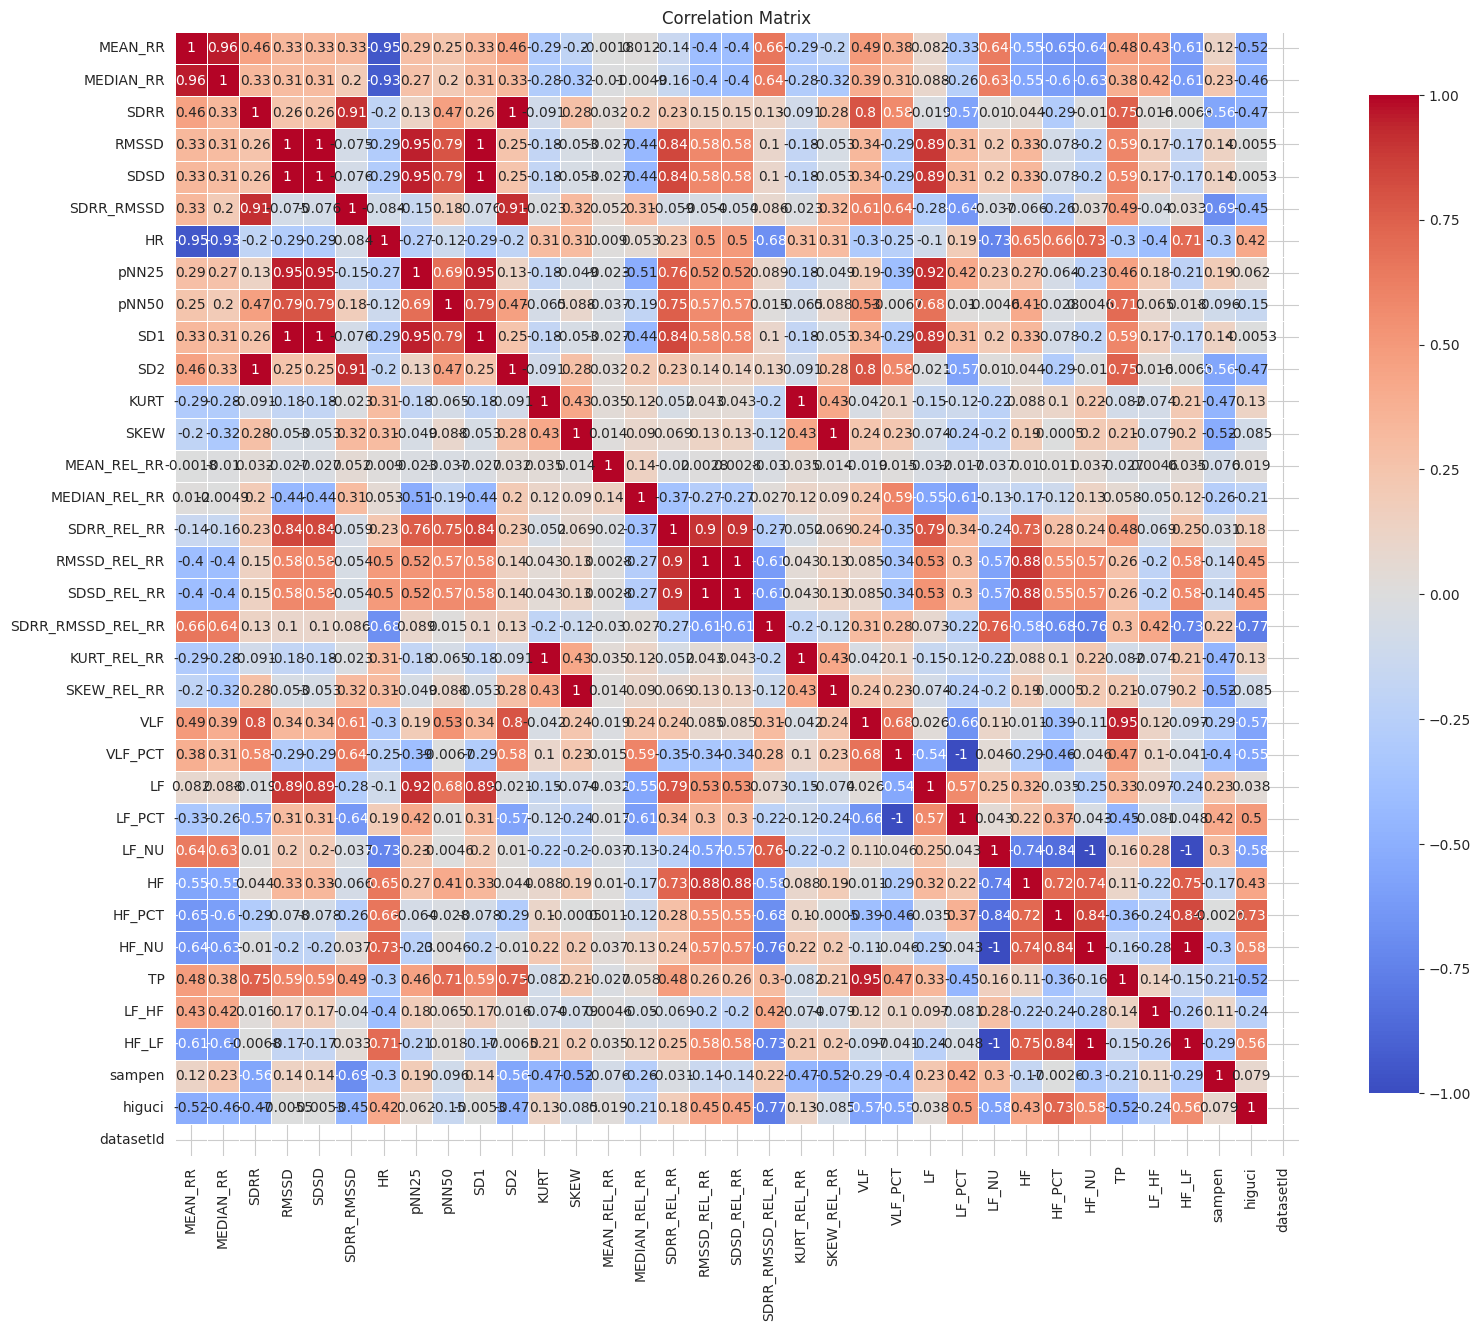

In [194]:
corr_matrix = test_numeric.corr()

plt.figure(figsize=(16, 14))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

## Examining The Cross Tabulations of Our Target For Each Feature


With a categorical target it can be hard to guage a feature importance. We can however use cross tabulations to give us some insight into the relationship between a feature and the target variable.

- Cross Tabs help us understand if there is an association between the feature and the categorical target.
- We create bins of the numerical variable and count the values of our categorical target that fall within each bin.
- With this, we can get a category wise distribution of our feature. If this varies between categories, we can conclude there may some association there.
- It's important to note that crosstabs only provide a univariate view of the relationship between one feature and the target, we can't assess the relationship between the target and multiple features here.
- Cross tabulations are a key part of a Chi2 test, this is a statistical measure of 



### Visualising the Crosstabulations

- It's very difficult to visualise the crosstabulations themselves, but what we can do instead is visualise the distributions of our variables grouped by our target feature. (below)
- What we want to see is minimal overlap between the distributions of a variable for a given target class, this would indicate this variable has good discriminatory power and would be informative for predicting the target. In practice we almost always have some overlap, so we are looking for features that minimise this.
- Significant overlap would suggest that the inverse, and the feature has a single distribution of values for all values of the target meaning it is a poor indicator of the target class.
- I
- We can now start to see some emergent features on the grid:
    -  **RMSSD & SDSD & pNN25** Appear to have significantly different distributions for each of our target classes. 'Interruption' has much more area to the right of the plot indicating someone in this state is likely to have a higher value. Where as the inverse is true for the 'no stress' state.
        -  The distributions for RMSSD & SDSD are multi-modal, indicating they may have a complex relationship with the target. 
    -  Interestingly, two very similar statistical features **Mean_Rel_RR and Median_Rel_RR** seem to have different relationships with the target variable. The Mean_Rel_RR  has very similar distributions for all classes where as the Median_Rel_RR is quite different.

**Recommendations**


Based on these observations, we can make informed decisions about feature selection:

1. Retain Informative Features: Features that exhibit good separability and have distinct distributions for different target categories are likely to be informative and should be retained for modeling. From our plots I would suggest that features like: Median_Rel_RR, pNN25, RMSSD,SDSD, SD1 and TP are good canditates for further exploration. 

2. Discard or Transform Overlapping Features: Features with significant overlap in their distributions across target categories may not be as useful for prediction. We could consider removing these features, such as: Mean_Rel_RR, SKEW and Kurt as they potential offer little discriminatory power.


### Quantifying Cross Tab Results

We should also consider quantifying these relationships, we can do that with a Chi2 test to give us a statistcal measure of how significant the relationship between our numerical feature and categorical target is. We can set a significance level 0.05 below which we can conclude there is a relationship between the variables. 

I picked two variables **Mean_Rel_RR and Median_Rel_RR** one of which is visually a bad feature, the other is good, to perform a statistical test on. 

**For 'MEAN_REL_RR' and 'condition'**:
- The Chi-square statistic is 1278.87. This measures the difference between the observed frequencies and the expected frequencies under the null hypothesis of independence.
- The p-value is 0.0000, which is less than the significance level of 0.05. This indicates strong evidence against the null hypothesis, suggesting a significant association between 'MEAN_REL_RR' and 'condition'.

For 'MEDIAN_REL_RR' and 'condition':
- The Chi-square statistic is 2505.06, indicating an even larger difference between the observed and expected frequencies compared to 'MEAN_REL_RR'.
- The p-value is also 0.0000, again strong evidence we should conclude there is an association.

Based on these results, we can conclude that both 'MEAN_REL_RR' and 'MEDIAN_REL_RR' have a statistically significant association with the 'condition' variable. The extremely low p-values indicate that the observed associations are unlikely to have occurred by chance alone.

However, it's important to note that while the Chi-square test establishes the presence of an association, it does not provide information about the strength or nature of the association. The visual assessment of the features, as mentioned earlier, can complement the statistical test results.





In [250]:
# Create an empty dictionary to store the contingency tables
contingency_tables = {}

# Iterate over each feature
for feature in numerical_columns:
    # Check if the feature is continuous
    if test[feature].dtype == "float64" or test[feature].dtype == "int64":
        # Create bins for the continuous feature
        bins = pd.cut(test[feature], bins=10)  # Adjust the number of bins as needed

        # Create a contingency table for the binned feature and the target variable
        contingency_table = pd.crosstab(bins, test["condition"])

        # Update the feature name to include the binning information
        feature_name = f"{feature}_binned"
    else:
        # Create a contingency table for the categorical feature and the target variable
        contingency_table = pd.crosstab(df[feature], df["condition"])
        feature_name = feature

    # Add the contingency table to the dictionary
    contingency_tables[feature_name] = contingency_table

# Print the contingency tables for each feature
for feature, table in contingency_tables.items():
    print(f"Contingency Table for {feature}:")
    display(table)
    print("\n")

Contingency Table for MEAN_RR_binned:


condition,interruption,no stress,time pressure
MEAN_RR,,,
"(546.71, 624.895]",108,474,253
"(624.895, 702.307]",149,2129,32
"(702.307, 779.718]",3369,6583,293
"(779.718, 857.129]",3571,5745,1535
"(857.129, 934.541]",1359,4363,1754
"(934.541, 1011.952]",1730,1605,1668
"(1011.952, 1089.363]",1000,932,585
"(1089.363, 1166.775]",318,171,648
"(1166.775, 1244.186]",178,46,290




Contingency Table for MEDIAN_RR_binned:


condition,interruption,no stress,time pressure
MEDIAN_RR,,,
"(516.157, 630.876]",220,833,276
"(630.876, 744.459]",742,6573,226
"(744.459, 858.042]",6445,8184,1697
"(858.042, 971.625]",1806,4954,2705
"(971.625, 1085.208]",2063,1266,1106
"(1085.208, 1198.791]",398,106,900
"(1198.791, 1312.374]",108,107,183
"(1312.374, 1425.956]",0,52,0
"(1425.956, 1539.539]",0,9,0




Contingency Table for SDRR_binned:


condition,interruption,no stress,time pressure
SDRR,,,
"(26.803, 80.914]",5440,12140,2117
"(80.914, 134.489]",4316,6364,2544
"(134.489, 188.065]",687,1619,1190
"(188.065, 241.64]",421,471,458
"(241.64, 295.215]",306,553,476
"(295.215, 348.791]",400,478,181
"(348.791, 402.366]",212,285,77
"(402.366, 455.942]",0,52,50
"(455.942, 509.517]",0,41,0




Contingency Table for RMSSD_binned:


condition,interruption,no stress,time pressure
RMSSD,,,
"(5.511, 7.636]",0,308,0
"(7.636, 9.74]",1237,2389,498
"(9.74, 11.844]",1043,4098,733
"(11.844, 13.948]",1771,4992,1231
"(13.948, 16.052]",1943,3571,1777
"(16.052, 18.156]",1386,2897,1402
"(18.156, 20.261]",1240,2012,1055
"(20.261, 22.365]",1653,1329,384
"(22.365, 24.469]",1001,560,13




Contingency Table for SDSD_binned:


condition,interruption,no stress,time pressure
SDSD,,,
"(5.51, 7.636]",0,308,0
"(7.636, 9.74]",1237,2389,498
"(9.74, 11.844]",1043,4098,733
"(11.844, 13.948]",1773,4993,1231
"(13.948, 16.052]",1942,3570,1777
"(16.052, 18.156]",1385,2897,1403
"(18.156, 20.26]",1241,2012,1054
"(20.26, 22.365]",1652,1329,384
"(22.365, 24.469]",1001,560,13




Contingency Table for SDRR_RMSSD_binned:


condition,interruption,no stress,time pressure
SDRR_RMSSD,,,
"(2.613, 7.842]",9616,16425,4540
"(7.842, 13.02]",1190,3740,1660
"(13.02, 18.197]",493,980,719
"(18.197, 23.374]",360,441,170
"(23.374, 28.552]",123,326,4
"(28.552, 33.729]",0,37,0
"(33.729, 38.907]",0,11,0
"(38.907, 44.084]",0,53,0
"(44.084, 49.262]",0,28,0




Contingency Table for HR_binned:


condition,interruption,no stress,time pressure
HR,,,
"(48.672, 55.239]",361,55,645
"(55.239, 61.74]",1720,1257,986
"(61.74, 68.242]",1731,3349,2341
"(68.242, 74.744]",2292,4536,2280
"(74.744, 81.246]",4520,5369,368
"(81.246, 87.747]",876,5121,182
"(87.747, 94.249]",56,1343,25
"(94.249, 100.751]",86,886,33
"(100.751, 107.253]",64,201,233




Contingency Table for pNN25_binned:


condition,interruption,no stress,time pressure
pNN25,,,
"(-0.0394, 3.94]",2440,7621,1236
"(3.94, 7.88]",2321,5865,1820
"(7.88, 11.82]",1605,4096,1889
"(11.82, 15.76]",1387,1615,1122
"(15.76, 19.7]",685,692,692
"(19.7, 23.64]",675,941,286
"(23.64, 27.58]",1101,757,48
"(27.58, 31.52]",904,544,0
"(31.52, 35.46]",381,27,0




Contingency Table for pNN50_binned:


condition,interruption,no stress,time pressure
pNN50,,,
"(-0.0054, 0.54]",5277,12906,3382
"(0.54, 1.08]",1633,3287,1256
"(1.08, 1.62]",1798,2216,901
"(1.62, 2.16]",1323,1428,523
"(2.16, 2.7]",669,1392,540
"(2.7, 3.24]",405,586,212
"(3.24, 3.78]",323,308,166
"(3.78, 4.32]",230,35,78
"(4.32, 4.86]",64,0,35




Contingency Table for SD1_binned:


condition,interruption,no stress,time pressure
SD1,,,
"(3.898, 5.401]",0,308,0
"(5.401, 6.889]",1237,2389,498
"(6.889, 8.378]",1043,4098,733
"(8.378, 9.866]",1773,4993,1231
"(9.866, 11.354]",1942,3570,1777
"(11.354, 12.843]",1385,2897,1403
"(12.843, 14.331]",1241,2012,1054
"(14.331, 15.819]",1652,1329,384
"(15.819, 17.308]",1001,560,13




Contingency Table for SD2_binned:


condition,interruption,no stress,time pressure
SD2,,,
"(37.697, 114.238]",5539,12166,2118
"(114.238, 190.022]",4219,6343,2544
"(190.022, 265.806]",686,1614,1189
"(265.806, 341.59]",420,470,458
"(341.59, 417.374]",306,554,476
"(417.374, 493.158]",400,478,181
"(493.158, 568.942]",212,285,77
"(568.942, 644.726]",0,52,50
"(644.726, 720.51]",0,41,0




Contingency Table for KURT_binned:


condition,interruption,no stress,time pressure
KURT,,,
"(-1.951, 3.76]",11776,20531,6786
"(3.76, 9.414]",6,1442,302
"(9.414, 15.069]",0,140,5
"(15.069, 20.723]",0,26,0
"(20.723, 26.378]",0,11,0
"(26.378, 32.032]",0,3,0
"(32.032, 37.687]",0,2,0
"(37.687, 43.342]",0,1,0
"(48.996, 54.651]",0,2,0




Contingency Table for SKEW_binned:


condition,interruption,no stress,time pressure
SKEW,,,
"(-2.145, -1.257]",18,449,57
"(-1.257, -0.378]",2869,4422,1760
"(-0.378, 0.502]",7526,12490,3947
"(0.502, 1.381]",1279,3099,1042
"(1.381, 2.26]",90,1192,258
"(2.26, 3.14]",0,445,29
"(3.14, 4.019]",0,39,0
"(4.019, 4.898]",0,18,0
"(4.898, 5.777]",0,3,0




Contingency Table for MEAN_REL_RR_binned:


condition,interruption,no stress,time pressure
MEAN_REL_RR,,,
"(-0.00128, -0.00103]",0,0,1
"(-0.00103, -0.000778]",5,21,2
"(-0.000778, -0.000529]",57,162,36
"(-0.000529, -0.00028]",333,627,361
"(-0.00028, -3.17e-05]",4083,7197,2499
"(-3.17e-05, 0.000217]",6677,12792,3753
"(0.000217, 0.000466]",499,959,374
"(0.000466, 0.000714]",101,313,55
"(0.000714, 0.000963]",24,80,8




Contingency Table for MEDIAN_REL_RR_binned:


condition,interruption,no stress,time pressure
MEDIAN_REL_RR,,,
"(-0.00443, -0.00378]",1,88,0
"(-0.00378, -0.00312]",57,213,0
"(-0.00312, -0.00247]",163,819,11
"(-0.00247, -0.00182]",549,1232,127
"(-0.00182, -0.00117]",1772,1627,577
"(-0.00117, -0.000523]",3151,4115,1824
"(-0.000523, 0.000127]",3957,8062,2475
"(0.000127, 0.000778]",1928,5472,1509
"(0.000778, 0.00143]",204,451,569




Contingency Table for SDRR_REL_RR_binned:


condition,interruption,no stress,time pressure
SDRR_REL_RR,,,
"(0.00896, 0.0117]",368,1009,419
"(0.0117, 0.0145]",1901,6320,1156
"(0.0145, 0.0173]",2371,4295,2549
"(0.0173, 0.02]",2050,3430,1513
"(0.02, 0.0228]",2024,2304,728
"(0.0228, 0.0255]",1415,1899,488
"(0.0255, 0.0283]",333,1250,71
"(0.0283, 0.0311]",324,1156,169
"(0.0311, 0.0338]",777,438,0




Contingency Table for RMSSD_REL_RR_binned:


condition,interruption,no stress,time pressure
RMSSD_REL_RR,,,
"(0.0032, 0.00558]",439,1564,1157
"(0.00558, 0.00795]",3992,7238,2422
"(0.00795, 0.0103]",2470,6669,2141
"(0.0103, 0.0127]",2240,1869,888
"(0.0127, 0.015]",1166,1780,125
"(0.015, 0.0174]",604,1508,295
"(0.0174, 0.0198]",697,837,65
"(0.0198, 0.0221]",28,474,0
"(0.0221, 0.0245]",56,170,0




Contingency Table for SDSD_REL_RR_binned:


condition,interruption,no stress,time pressure
SDSD_REL_RR,,,
"(0.0032, 0.00558]",439,1564,1157
"(0.00558, 0.00795]",3992,7238,2422
"(0.00795, 0.0103]",2470,6668,2141
"(0.0103, 0.0127]",2240,1870,888
"(0.0127, 0.015]",1166,1780,125
"(0.015, 0.0174]",604,1508,295
"(0.0174, 0.0198]",697,837,65
"(0.0198, 0.0221]",28,474,0
"(0.0221, 0.0245]",56,170,0




Contingency Table for SDRR_RMSSD_REL_RR_binned:


condition,interruption,no stress,time pressure
SDRR_RMSSD_REL_RR,,,
"(1.184, 1.438]",187,1012,0
"(1.438, 1.69]",1794,3989,863
"(1.69, 1.942]",4084,7508,1380
"(1.942, 2.194]",2982,4225,2056
"(2.194, 2.446]",1477,3526,976
"(2.446, 2.698]",738,1176,889
"(2.698, 2.95]",314,408,398
"(2.95, 3.202]",159,238,445
"(3.202, 3.454]",35,76,52




Contingency Table for KURT_REL_RR_binned:


condition,interruption,no stress,time pressure
KURT_REL_RR,,,
"(-1.951, 3.76]",11776,20531,6786
"(3.76, 9.414]",6,1442,302
"(9.414, 15.069]",0,140,5
"(15.069, 20.723]",0,26,0
"(20.723, 26.378]",0,11,0
"(26.378, 32.032]",0,3,0
"(32.032, 37.687]",0,2,0
"(37.687, 43.342]",0,1,0
"(48.996, 54.651]",0,2,0




Contingency Table for SKEW_REL_RR_binned:


condition,interruption,no stress,time pressure
SKEW_REL_RR,,,
"(-2.145, -1.257]",18,449,57
"(-1.257, -0.378]",2869,4422,1760
"(-0.378, 0.502]",7526,12490,3947
"(0.502, 1.381]",1279,3099,1042
"(1.381, 2.26]",90,1192,258
"(2.26, 3.14]",0,445,29
"(3.14, 4.019]",0,39,0
"(4.019, 4.898]",0,18,0
"(4.898, 5.777]",0,3,0




Contingency Table for VLF_binned:


condition,interruption,no stress,time pressure
VLF,,,
"(148.603, 1387.501]",5496,9413,1710
"(1387.501, 2614.131]",3602,8110,2140
"(2614.131, 3840.762]",1214,2424,1051
"(3840.762, 5067.393]",363,1220,887
"(5067.393, 6294.024]",357,598,705
"(6294.024, 7520.654]",232,188,179
"(7520.654, 8747.285]",242,158,299
"(8747.285, 9973.916]",114,47,122
"(9973.916, 11200.547]",61,0,0




Contingency Table for VLF_PCT_binned:


condition,interruption,no stress,time pressure
VLF_PCT,,,
"(19.223, 27.145]",485,218,0
"(27.145, 34.989]",648,1257,203
"(34.989, 42.833]",967,1580,134
"(42.833, 50.677]",1236,1839,343
"(50.677, 58.521]",1569,2867,558
"(58.521, 66.364]",2298,3324,1094
"(66.364, 74.208]",2186,3945,1087
"(74.208, 82.052]",1063,4468,1884
"(82.052, 89.896]",725,2165,1150




Contingency Table for LF_binned:


condition,interruption,no stress,time pressure
LF,,,
"(89.467, 412.407]",1539,3440,572
"(412.407, 732.15]",2479,7710,2766
"(732.15, 1051.893]",2528,4819,2138
"(1051.893, 1371.636]",1205,2958,865
"(1371.636, 1691.379]",1391,1188,461
"(1691.379, 2011.122]",1128,1126,248
"(2011.122, 2330.865]",492,530,43
"(2330.865, 2650.608]",297,373,0
"(2650.608, 2970.351]",386,14,0




Contingency Table for LF_PCT_binned:


condition,interruption,no stress,time pressure
LF_PCT,,,
"(2.089, 9.7]",604,527,616
"(9.7, 17.236]",756,2391,1097
"(17.236, 24.771]",1025,4239,1887
"(24.771, 32.307]",2218,4052,1207
"(32.307, 39.843]",2263,3537,1020
"(39.843, 47.379]",1421,2845,599
"(47.379, 54.915]",1431,1581,320
"(54.915, 62.451]",921,1505,148
"(62.451, 69.987]",703,1300,184




Contingency Table for LF_NU_binned:


condition,interruption,no stress,time pressure
LF_NU,,,
"(70.653, 73.613]",25,17,0
"(73.613, 76.543]",62,35,0
"(76.543, 79.474]",18,165,0
"(79.474, 82.404]",0,201,0
"(82.404, 85.335]",93,230,35
"(85.335, 88.265]",354,1207,83
"(88.265, 91.196]",1011,1930,91
"(91.196, 94.126]",1377,4020,774
"(94.126, 97.057]",3110,5910,1424




Contingency Table for HF_binned:


condition,interruption,no stress,time pressure
HF,,,
"(-0.298, 36.144]",7890,13542,5775
"(36.144, 72.226]",1643,4995,989
"(72.226, 108.307]",959,1130,82
"(108.307, 144.389]",903,1530,156
"(144.389, 180.47]",223,470,47
"(180.47, 216.552]",36,173,31
"(216.552, 252.633]",54,160,13
"(252.633, 288.715]",43,76,0
"(288.715, 324.796]",27,55,0




Contingency Table for HF_PCT_binned:


condition,interruption,no stress,time pressure
HF_PCT,,,
"(-0.0109, 1.311]",7246,11054,5387
"(1.311, 2.619]",1926,5830,1079
"(2.619, 3.928]",1494,2158,481
"(3.928, 5.236]",682,1867,116
"(5.236, 6.545]",104,722,29
"(6.545, 7.854]",122,251,1
"(7.854, 9.162]",150,112,0
"(9.162, 10.471]",58,48,0
"(10.471, 11.779]",0,77,0




Contingency Table for HF_NU_binned:


condition,interruption,no stress,time pressure
HF_NU,,,
"(-0.0163, 2.943]",5732,8443,4686
"(2.943, 5.874]",3110,5910,1424
"(5.874, 8.804]",1377,4020,774
"(8.804, 11.735]",1011,1930,91
"(11.735, 14.665]",354,1207,83
"(14.665, 17.596]",93,230,35
"(17.596, 20.526]",0,201,0
"(20.526, 23.457]",18,165,0
"(23.457, 26.387]",62,35,0




Contingency Table for TP_binned:


condition,interruption,no stress,time pressure
TP,,,
"(365.182, 1665.199]",2419,5058,1141
"(1665.199, 2952.345]",2896,8642,1925
"(2952.345, 4239.49]",3847,4746,1159
"(4239.49, 5526.635]",1321,2220,1182
"(5526.635, 6813.781]",479,933,911
"(6813.781, 8100.926]",211,259,366
"(8100.926, 9388.072]",271,233,308
"(9388.072, 10675.217]",153,67,101
"(10675.217, 11962.362]",77,0,0




Contingency Table for LF_HF_binned:


condition,interruption,no stress,time pressure
LF_HF,,,
"(-5.295, 773.007]",11266,22048,6718
"(773.007, 1543.603]",320,110,84
"(1543.603, 2314.199]",192,0,18
"(2314.199, 3084.795]",4,0,179
"(3084.795, 3855.39]",0,0,25
"(3855.39, 4625.986]",0,0,8
"(4625.986, 5396.582]",0,0,9
"(5396.582, 6167.178]",0,0,16
"(6167.178, 6937.774]",0,0,28




Contingency Table for HF_LF_binned:


condition,interruption,no stress,time pressure
HF_LF,,,
"(-0.000285, 0.0416]",7066,11158,5101
"(0.0416, 0.0831]",2703,6079,1689
"(0.0831, 0.125]",1346,2706,166
"(0.125, 0.166]",422,1474,80
"(0.166, 0.207]",140,308,56
"(0.207, 0.249]",0,174,1
"(0.249, 0.29]",5,179,0
"(0.29, 0.332]",48,53,0
"(0.332, 0.373]",37,17,0




Contingency Table for sampen_binned:


condition,interruption,no stress,time pressure
sampen,,,
"(0.434, 0.616]",0,55,0
"(0.616, 0.795]",0,95,0
"(0.795, 0.975]",0,95,0
"(0.975, 1.155]",0,189,0
"(1.155, 1.335]",0,303,0
"(1.335, 1.515]",16,351,0
"(1.515, 1.695]",189,865,213
"(1.695, 1.875]",622,1451,414
"(1.875, 2.055]",1199,4035,1443




Contingency Table for higuci_binned:


condition,interruption,no stress,time pressure
higuci,,,
"(1.034, 1.067]",146,179,412
"(1.067, 1.1]",569,1186,1056
"(1.1, 1.132]",1332,2107,1040
"(1.132, 1.165]",2401,6026,1286
"(1.165, 1.198]",2256,4362,1379
"(1.198, 1.23]",2055,3159,1045
"(1.23, 1.263]",1251,2458,427
"(1.263, 1.295]",869,1439,310
"(1.295, 1.328]",528,1091,138




Contingency Table for datasetId_binned:


condition,interruption,no stress,time pressure
datasetId,,,
"(1.9996, 2.0]",11782,22158,7093


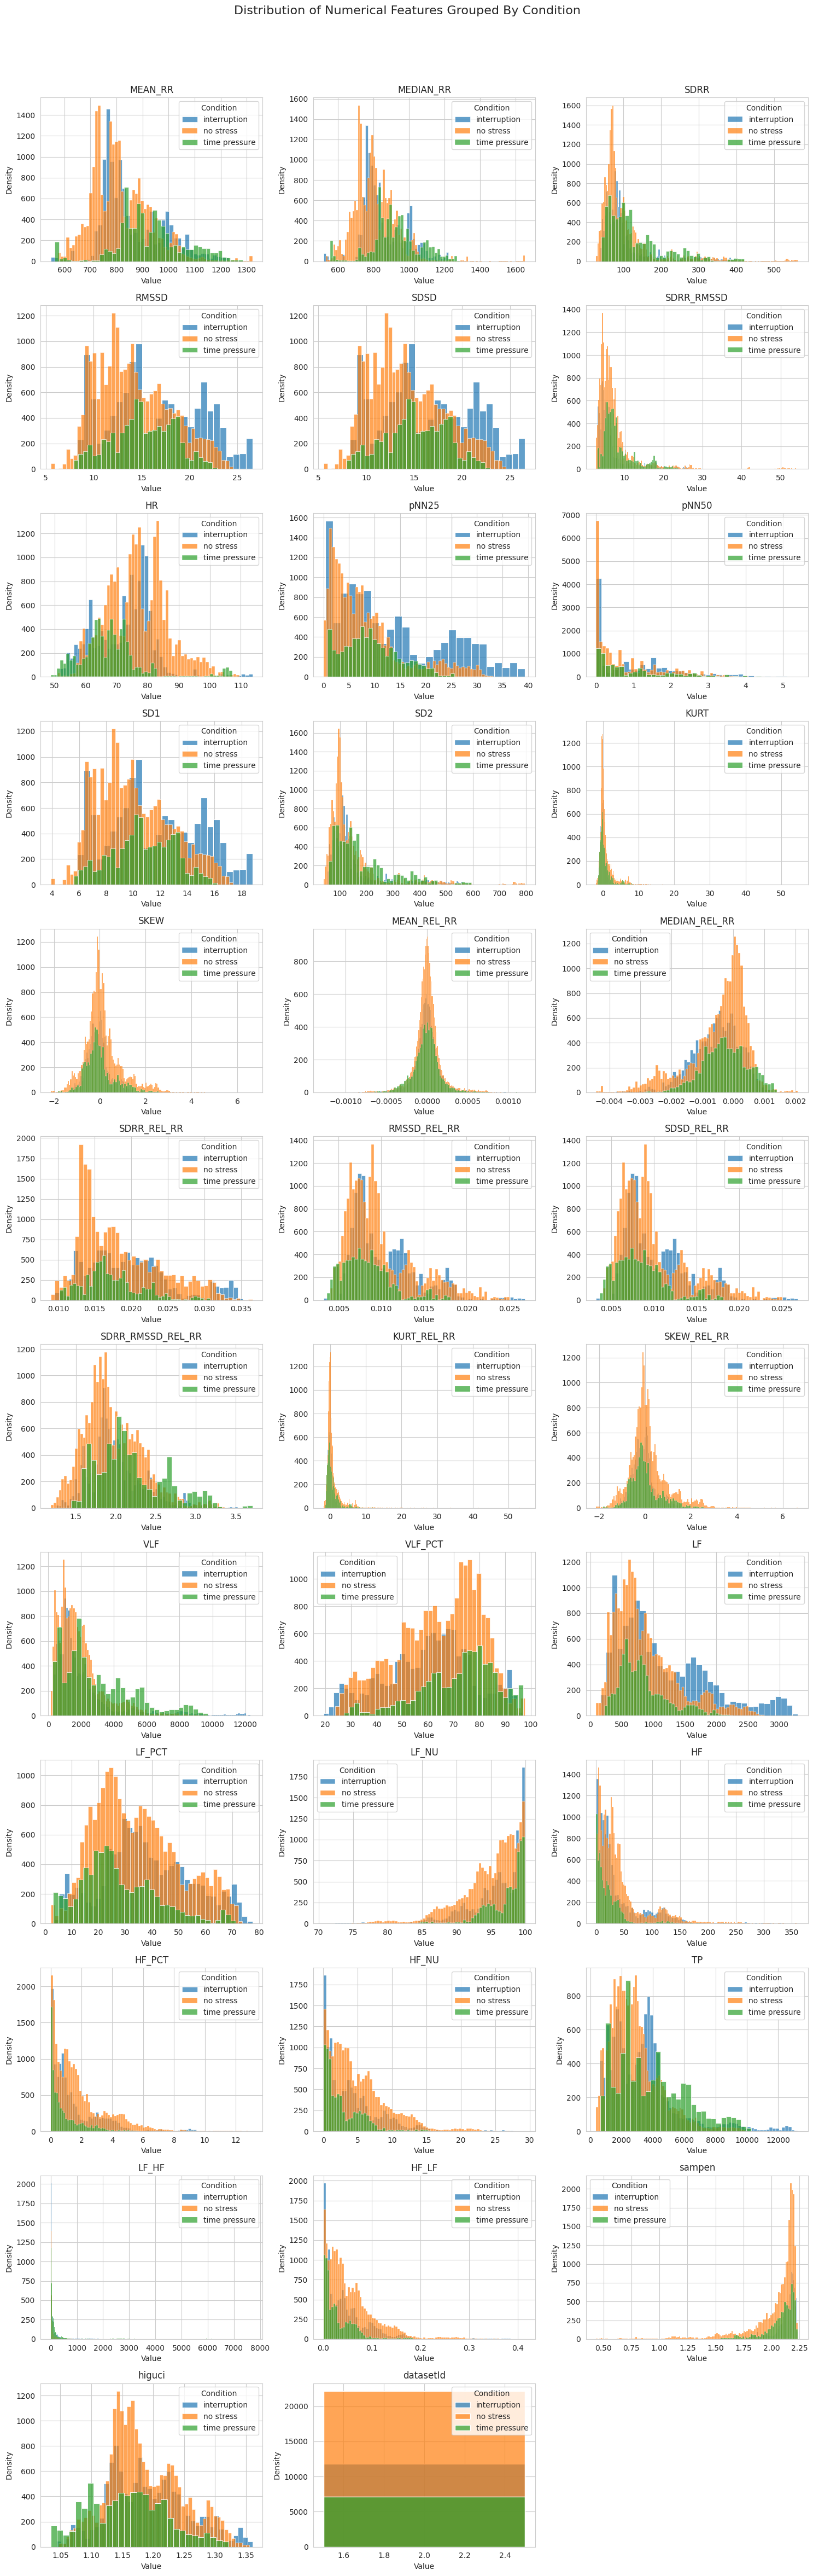

In [252]:
# Group the 'test' dataset by the 'condition' target
grouped_data = test.groupby("condition")

# Create a grid of subplots
num_features = len(feature_names)
num_rows = (num_features + 2) // 3  # Calculate the number of rows needed for the grid
num_cols = 3  # Set the number of columns in the grid

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))
plt.suptitle("Distribution of Numerical Features Grouped By Condition", fontsize=16)

axes = axes.flatten()

for i, feature in enumerate(numerical_columns):
    ax = axes[i]

    # Plot the distribution for each target category
    for condition, data in grouped_data:
        sns.histplot(data[feature], ax=ax, label=condition, alpha=0.7)

    ax.set_title(feature)
    ax.set_xlabel("Value")
    ax.set_ylabel("Density")
    ax.legend(title="Condition")

# Remove any unused subplots
for i in range(num_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the top parameter to make space for the suptitle

plt.show()

In [239]:
# Perform chi-square test for 'MEAN_REL_RR' and 'condition'
mean_rr_table = contingency_tables["MEAN_REL_RR_binned"]
chi2_mean_rr, p_mean_rr, dof_mean_rr, expected_mean_rr = chi2_contingency(mean_rr_table)

print("Chi-square test for 'MEAN_REL_RR' and 'condition':")
print(f"Chi-square statistic: {chi2_mean_rr:.2f}")
print(f"p-value: {p_mean_rr:.4f}")
print(f"Degrees of freedom: {dof_mean_rr}")
print()

# Perform chi-square test for 'MEDIAN_REL_RR' and 'condition'
median_rr_table = contingency_tables["MEDIAN_REL_RR_binned"]
chi2_median_rr, p_median_rr, dof_median_rr, expected_median_rr = chi2_contingency(
    median_rr_table
)

print("Chi-square test for 'MEDIAN_REL_RR' and 'condition':")
print(f"Chi-square statistic: {chi2_median_rr:.2f}")
print(f"p-value: {p_median_rr:.4f}")
print(f"Degrees of freedom: {dof_median_rr}")

Chi-square test for 'MEAN_REL_RR' and 'condition':
Chi-square statistic: 1278.87
p-value: 0.0000
Degrees of freedom: 18

Chi-square test for 'MEDIAN_REL_RR' and 'condition':
Chi-square statistic: 2505.06
p-value: 0.0000
Degrees of freedom: 18


## Summary

In this notebook, I have explored the provided dataset with the hypothetical goal of understanding the available features better to later build a supervised classification model. 

I started by comparing the train and test sets to ensure they shared similar distributions of features and classes, which is crucial for training a robust model.

Next, I analyzed the feature scales and correlations. I discovered that the features had widely varying scales, which can be problematic for distance-based methods and gradient descent optimization. I discussed potential solutions, such as using scale-invariant models like tree-based methods or applying feature scaling techniques like Z-score normalization or min-max scaling (Using training data for calculations to avoid leakage).

I also identified high correlations among some features, indicating redundancy in the feature space. To address this, I recommended several approaches, including feature selection based on domain knowledge, correlation analysis, or using dimensionality reduction techniques like PCA or SVD. Regularization techniques like L1 or L2 regularization were also suggested to mitigate the impact of high correlations.

To gain insights into the relationship between individual features and the target variable, we employed cross tabulations. By visualizing the distributions of features grouped by the target classes, I identified features with good discriminatory power, such as RMSSD, SDSD, and pNN25. These features exhibited distinct distributions for different stress states, making them promising candidates for further exploration. On the other hand, features like Mean_Rel_RR and SKEW showed significant overlap in their distributions across target categories, suggesting they may have limited predictive value.

To quantify the relationships between features and the target variable, we performed Chi-square tests on two selected features: Mean_Rel_RR and Median_Rel_RR. The results confirmed a statistically significant association between both features and the stress condition, with extremely low p-values. However, the visual assessment indicated that Median_Rel_RR might be more informative than Mean_Rel_RR.

## Next Steps

There are obviously many directions you could take this analysis in, in terms of our hypothetical goal of training a classifier model I would next move to:

1. Feature Selection: Utilize the insights gained from cross tabulations, visual assessments, and statistical tests to select a subset of informative features. Consider features with good discriminatory power and distinct distributions across target classes. It may even be useful to generate several candidate feature sets for future evaluation for use with different model types. 
   
3. Data Preprocessing: Apply appropriate feature scaling techniques to address the varying scales of the features. Standardize or normalize the features based on the requirements of the chosen model.

4. Depending on the model types, the distributions of the variables may be of importance. We should consider the assumptions of any model we choose to use and ensure that our data meets those assumptions such as normality of features etc. 

5. Model Selection: Experiment with different classification algorithms, such as tree-based methods (e.g., Random Forest, Gradient Boosting), support vector machines (SVM), or Neural Networks. Consider the characteristics of the dataset and the interpretability requirements of the problem domain. I would likely use a small subset of data to train many candidate model types first, gradually scaling up the data size and eliminating candidates as I go.

6. Hyperparameter Tuning: Perform hyperparameter optimization to find the best combination of model parameters that maximize performance on the validation set. Use techniques like grid search or random search to explore the hyperparameter space efficiently.

7. Model Evaluation: Assess the performance of the trained models using appropriate evaluation metrics, such as accuracy, precision, recall, and F1-score. Use cross-validation techniques to obtain robust estimates of model performance and mitigate overfitting.

8. Model Deployment and Monitoring: Once a satisfactory model is developed, deploy it in a production environment and establish a monitoring system to track its performance over time. Continuously collect feedback and new data to refine and update the model as needed.

I hope you enjoyed reading my submission, it was a lot of fun building the transformer and getting my dipping my toes in a completely new domain. If you have any questions i'd be happy to answer them.